<a href="https://colab.research.google.com/github/jihandewana/ML-User-Classification/blob/main/User_Classification_JihanDewana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library & Load Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as st

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.feature_selection import RFE
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from tabulate import tabulate

In [ ]:
#load dataset
from google.colab import files
uploaded = files.upload()

Saving ml_datasource.csv to ml_datasource.csv


In [ ]:
#read dataset
data = pd.read_csv('ml_datasource.csv')
data.head()

,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_started,practice_exams_passed,minutes_spent_on_exams,purchased
0,US,288,358.1,1,2,2,15.81,0
1,SG,260,1.7,1,1,0,16.00,0
2,TR,260,22.4,1,1,0,0.93,0
3,KE,259,18.8,1,1,1,14.63,0
4,IN,259,118.0,2,2,1,16.48,0


# EDA (1): Data Info, Data Describe & Checking Outliers

In [ ]:
#data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17761 entries, 0 to 17760
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   student_country         17752 non-null  object 
 1   days_on_platform        17761 non-null  int64  
 2   minutes_watched         17761 non-null  float64
 3   courses_started         17761 non-null  int64  
 4   practice_exams_started  17761 non-null  int64  
 5   practice_exams_passed   17761 non-null  int64  
 6   minutes_spent_on_exams  17761 non-null  float64
 7   purchased               17761 non-null  int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 1.1+ MB


In [ ]:
## Get descriptive statistics for numerical columns
data.describe()

,days_on_platform,minutes_watched,courses_started,practice_exams_started,practice_exams_passed,minutes_spent_on_exams,purchased
count,17761.000000,17761.000000,17761.000000,17761.000000,17761.000000,17761.000000,17761.000000
mean,123.205112,31.082906,1.196442,0.277800,0.176341,1.242772,0.091830
std,90.675102,90.593660,0.646788,1.659998,1.099900,7.755386,0.288795
min,0.000000,0.100000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,42.000000,1.100000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,113.000000,6.800000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,204.000000,34.300000,1.000000,0.000000,0.000000,0.000000,0.000000
max,292.000000,5312.300000,16.000000,76.000000,63.000000,457.410000,1.000000


In [ ]:
#Checking Outlier using Interquartile Range (IQR) Method
def find_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    if not outliers.empty:
        print(f"Outliers found in '{column}' using IQR method:")
        print(outliers)
    else:
        print(f"No outliers found in '{column}' using IQR method.")

In [ ]:
numerical_columns = ['days_on_platform', 'minutes_watched', 'courses_started', 'practice_exams_started', 'practice_exams_passed', 'minutes_spent_on_exams']

for col in numerical_columns:
    find_outliers_iqr(data, col)

No outliers found in 'days_on_platform' using IQR method.
Outliers found in 'minutes_watched' using IQR method:
      student_country  days_on_platform  minutes_watched  courses_started  \
0                  US               288            358.1                1   
4                  IN               259            118.0                2   
5                  IN               252            143.8                1   
7                  US               254            103.9                3   
10                 IT                 5            252.4                3   
...               ...               ...              ...              ...   
17648              CA                 1            148.3                1   
17677              US                 1             96.7                1   
17708              US                 0            104.4                1   
17711              IN                 0            214.6                1   
17713              US                 0  

In [ ]:
# Removing Outliers based on observed ranges and reasonable thresholds.
# We are creating a new DataFrame `data_no_outliers` by filtering the original `data`.
# The conditions are set to exclude extreme values that are likely outliers.
# For 'minutes_watched', values above 1000 are filtered out.
# For 'courses_started', values above 10 are filtered out.
# For 'practice_exams_started', values above 10 are filtered out.
# For 'practice_exams_passed', values above 10 are filtered out (similar to started exams).
# For 'minutes_spent_on_exams', values above 40 are filtered out.
data_no_outliers = data[(data['minutes_watched'] <= 1000) &
                        (data['courses_started'] <= 10) &
                        (data['practice_exams_started'] <= 10) &
                        (data['practice_exams_passed'] <= 10) &
                        (data['minutes_spent_on_exams'] <= 40)]

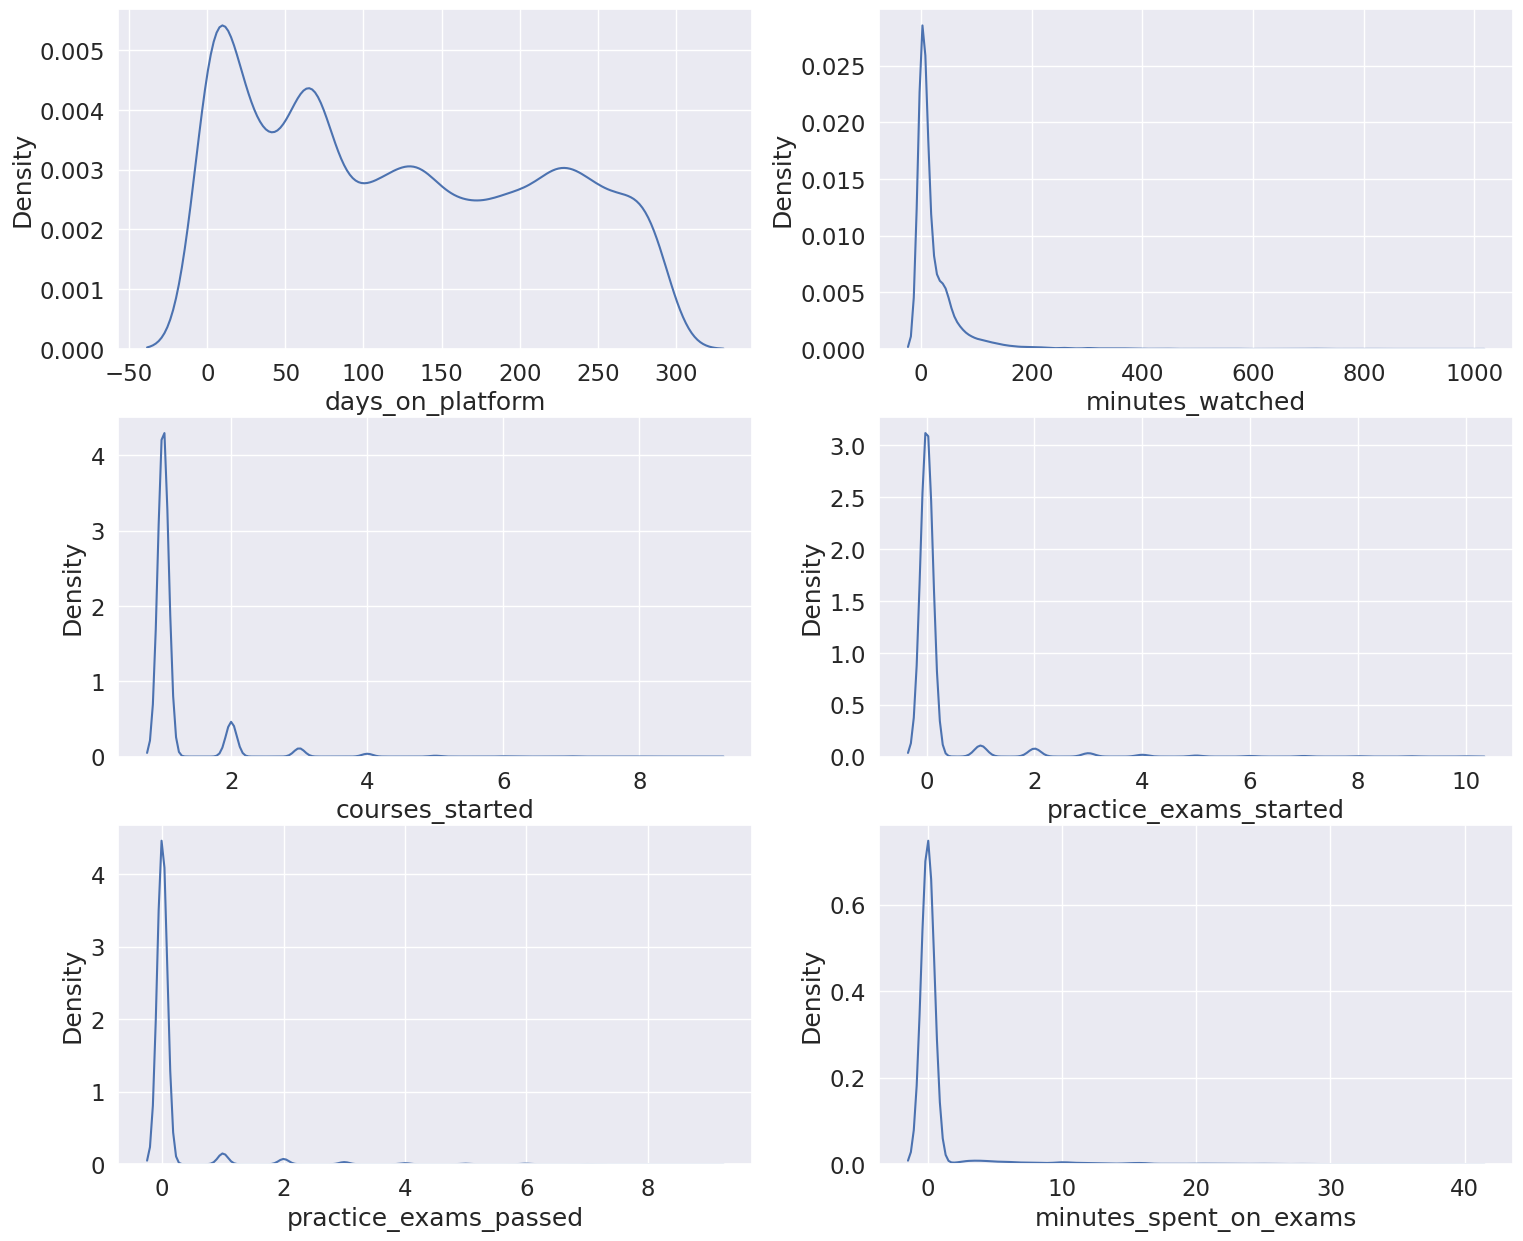

In [ ]:
#Checking Outlier (2) after removing outliers using Distribution Plot

#Reset any modification to the plotting
sns.reset_orig()
#Set the font scale for plots
sns.set(font_scale=1.5)
#Initialize a grid pf plots with specific dimensions
fig, axes = plt.subplots(3,2, figsize=(18,15))

#Plotting distribution plots for each of columns dataset
sns.kdeplot(data=data_no_outliers['days_on_platform'], ax=axes[0,0])
sns.kdeplot(data=data_no_outliers['minutes_watched'], ax=axes[0,1])
sns.kdeplot(data=data_no_outliers['courses_started'], ax=axes[1,0])
sns.kdeplot(data=data_no_outliers['practice_exams_started'],ax=axes[1,1])
sns.kdeplot(data=data_no_outliers['practice_exams_passed'],ax=axes[2,0])
sns.kdeplot(data=data_no_outliers['minutes_spent_on_exams'], ax=axes[2,1])

plt.show()

# EDA (2): Checking Multicolinearity (VIF), NaN Value

In [ ]:
#Checking Multicolinearity (1)
#Selecting numerical columns for VIF calculation
variables= data_no_outliers[['days_on_platform',
                             'minutes_watched',
                             'courses_started',
                             'practice_exams_started',
                             'practice_exams_passed',
                             'minutes_spent_on_exams']]
#Creating a DataFrame to store the VIF
vif = pd.DataFrame()
#Computing the VIF
vif['VIF'] = [variance_inflation_factor(variables.to_numpy(), i)
             for i in range(variables.shape[1])]
#Storing the names of the features in a column called "features"
vif['features'] = variables.columns
#Displaying the DataFrame
vif

,VIF,features
0,2.301237,days_on_platform
1,1.788777,minutes_watched
2,3.178713,courses_started
3,10.201823,practice_exams_started
4,7.812546,practice_exams_passed
5,3.345478,minutes_spent_on_exams


In [ ]:
#Droping the biggest VIF value >> indicate multicolinearity (VIF>5 or VIF>10)
data_no_mult = data_no_outliers.drop('practice_exams_started', axis = 1)
data_no_mult.head()

,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_passed,minutes_spent_on_exams,purchased
0,US,288,358.1,1,2,15.81,0
1,SG,260,1.7,1,0,16.00,0
2,TR,260,22.4,1,0,0.93,0
3,KE,259,18.8,1,1,14.63,0
4,IN,259,118.0,2,1,16.48,0


In [ ]:
#Checking Multicolinearity (2)
#Selecting numerical columns for VIF calculation
variables= data_no_mult[['days_on_platform',
                          'minutes_watched',
                          'courses_started',
                          'practice_exams_passed',
                          'minutes_spent_on_exams']]
#Creating a DataFrame to store the VIF
vif = pd.DataFrame()
#Computing the VIF
vif['VIF'] = [variance_inflation_factor(variables.to_numpy(), i)
             for i in range(variables.shape[1])]
#Storing the names of the features in a column called "features"
vif['features'] = variables.columns
#Displaying the DataFrame
vif

,VIF,features
0,2.299940,days_on_platform
1,1.788276,minutes_watched
2,3.174319,courses_started
3,2.562412,practice_exams_passed
4,2.602966,minutes_spent_on_exams


In [ ]:
#Checking the Nan Value
data_no_mult.isnull().sum()

,0
student_country,8
days_on_platform,0
minutes_watched,0
courses_started,0
practice_exams_passed,0
minutes_spent_on_exams,0
purchased,0


In [ ]:
#Dealing with NaN / NULL on "Student_Country"
data_no_mult.loc[ data_no_mult['student_country'].isna()]

,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_passed,minutes_spent_on_exams,purchased
311,NaN,88,58.1,1,2,11.20,1
337,NaN,86,43.0,1,2,12.96,0
556,NaN,121,241.9,2,3,21.29,0
806,NaN,64,86.4,1,2,4.98,0
1097,NaN,72,67.5,1,1,6.27,0
12363,NaN,84,6.2,1,0,0.00,0
12633,NaN,78,3.0,1,0,0.00,0
16946,NaN,11,8.2,1,0,0.00,0


In [ ]:
# Calculate the mode (most frequent category) of the 'student_country' column
mode_student_country = data_no_mult['student_country'].mode()[0]

# Fill NaN values in 'student_country' with the calculated mode
data_no_nulls = data_no_mult.copy()
data_no_nulls['student_country'] = data_no_nulls['student_country'].fillna(mode_student_country)

# Display records where 'student_country' was previously NaN to verify the change (or a sample of the dataframe)
display(data_no_nulls.head())


,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_passed,minutes_spent_on_exams,purchased
0,US,288,358.1,1,2,15.81,0
1,SG,260,1.7,1,0,16.00,0
2,TR,260,22.4,1,0,0.93,0
3,KE,259,18.8,1,1,14.63,0
4,IN,259,118.0,2,1,16.48,0


In [ ]:
# Re-checking the number of null values in each column after replacement
data_no_nulls.isnull().sum()

,0
student_country,0
days_on_platform,0
minutes_watched,0
courses_started,0
practice_exams_passed,0
minutes_spent_on_exams,0
purchased,0


# Data Visualization

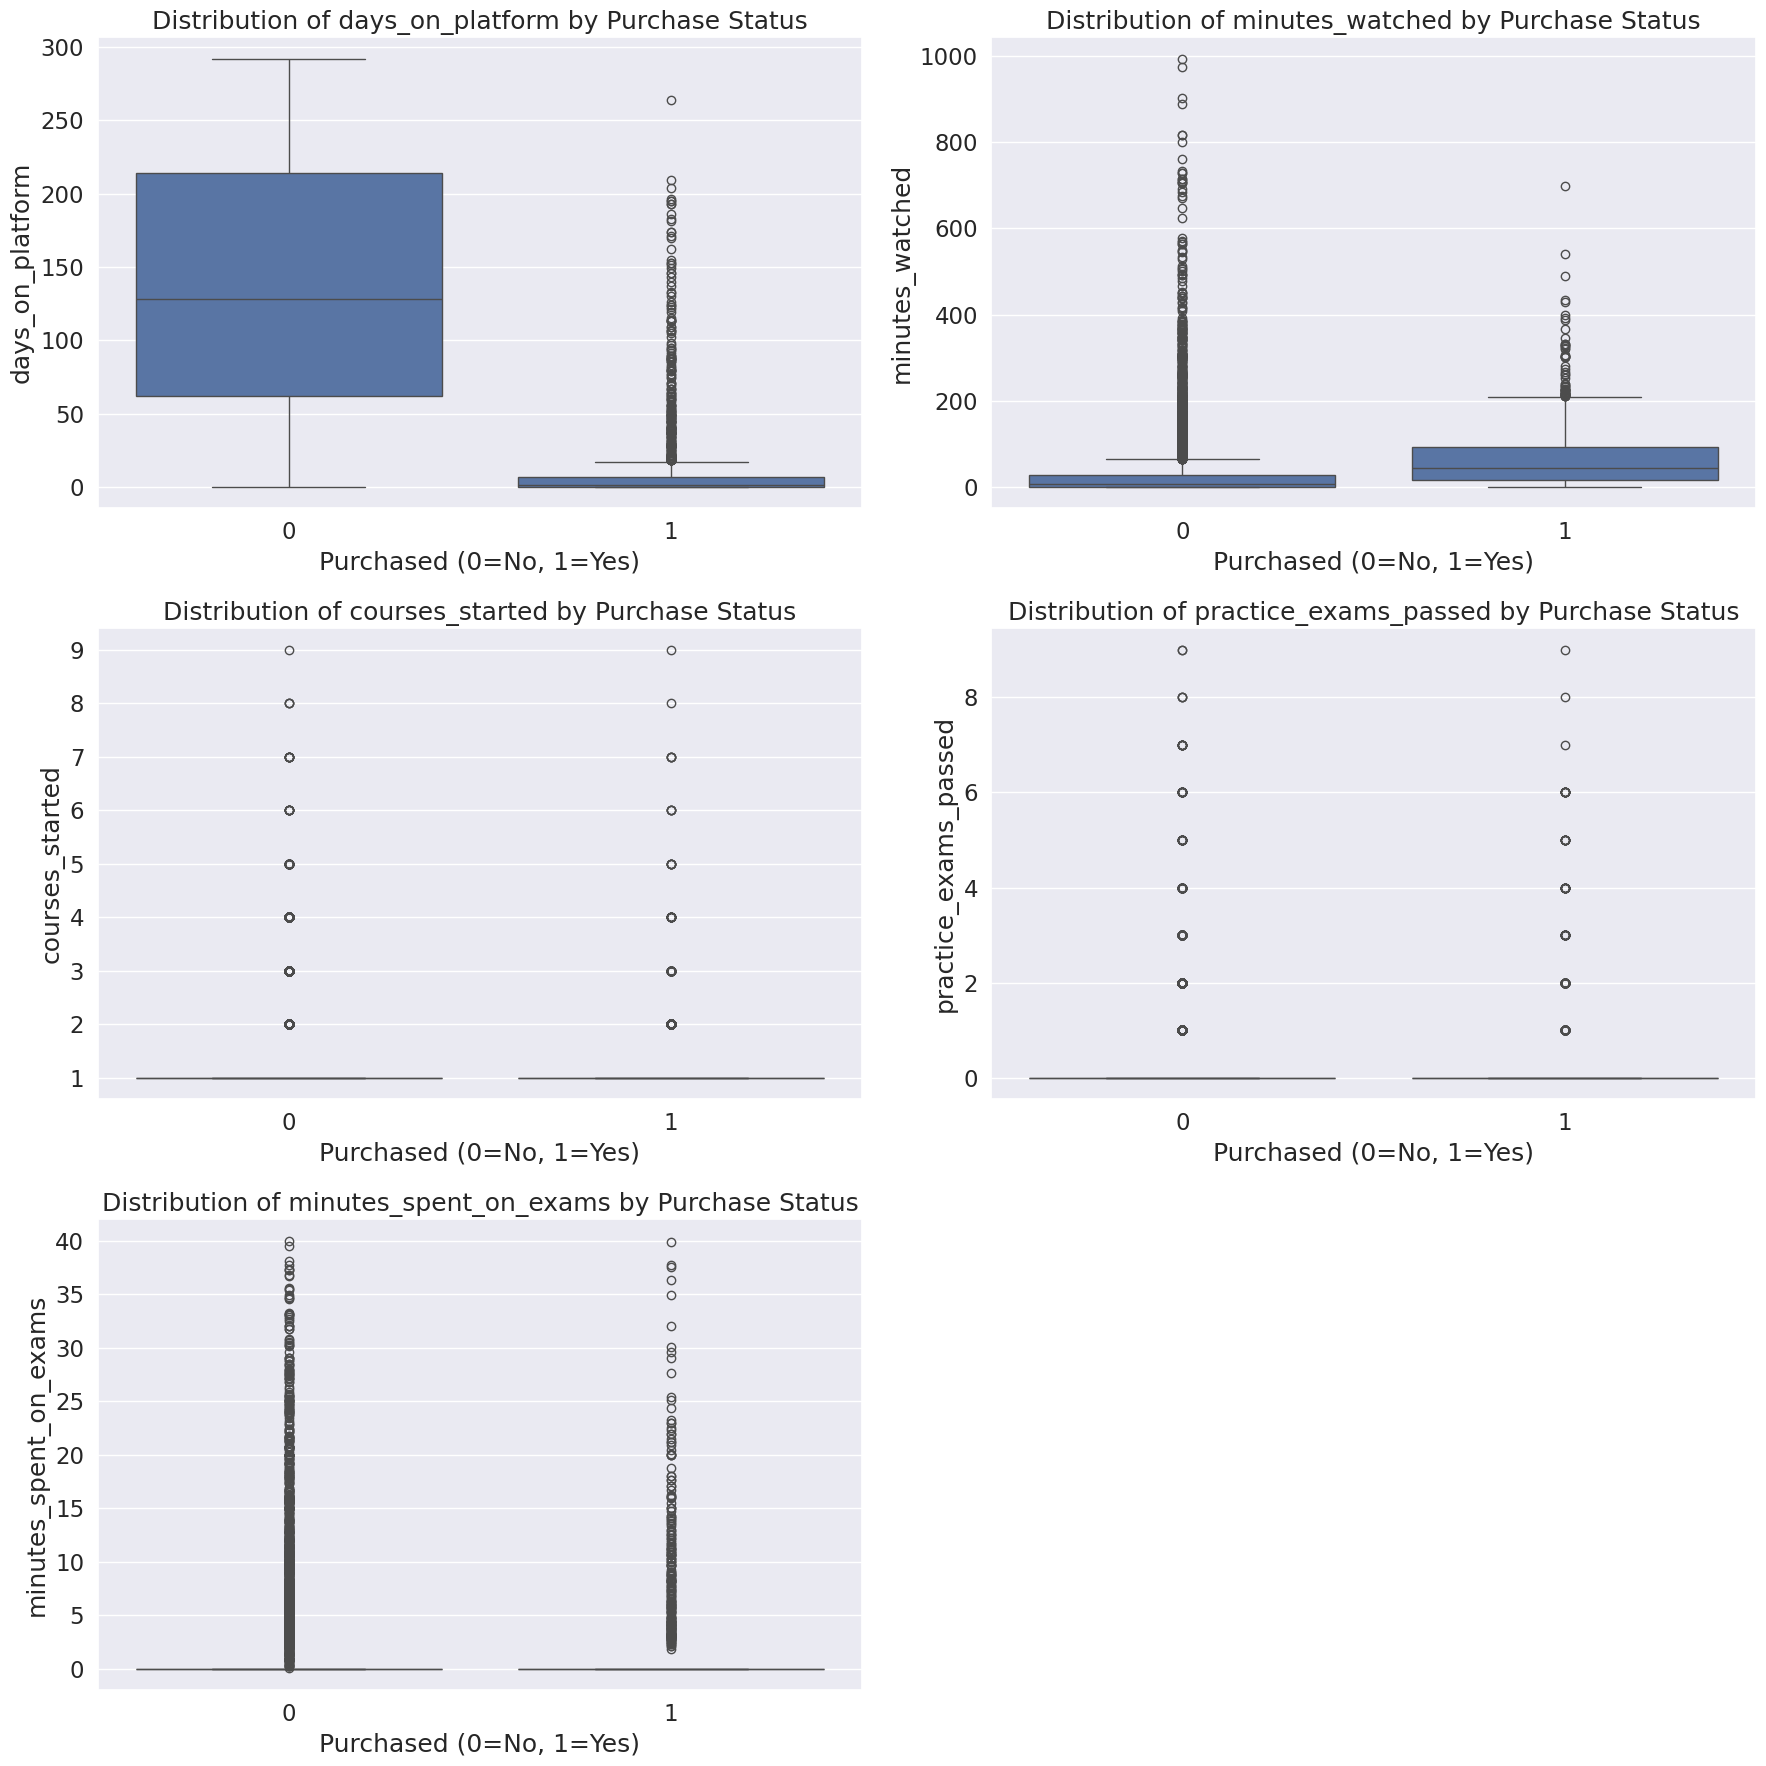

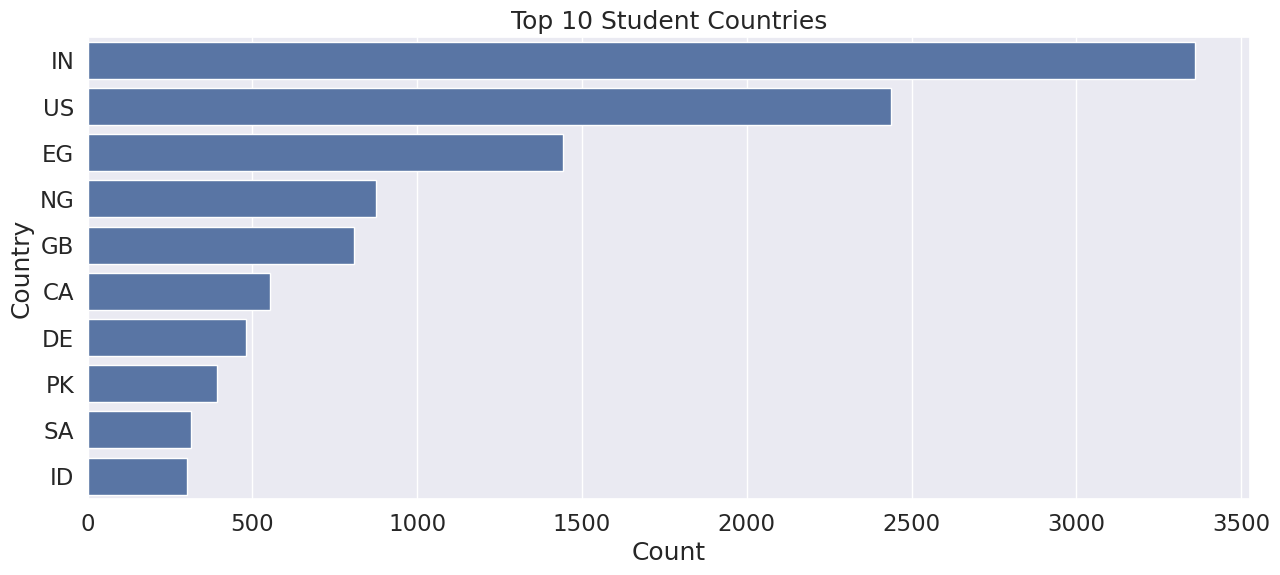

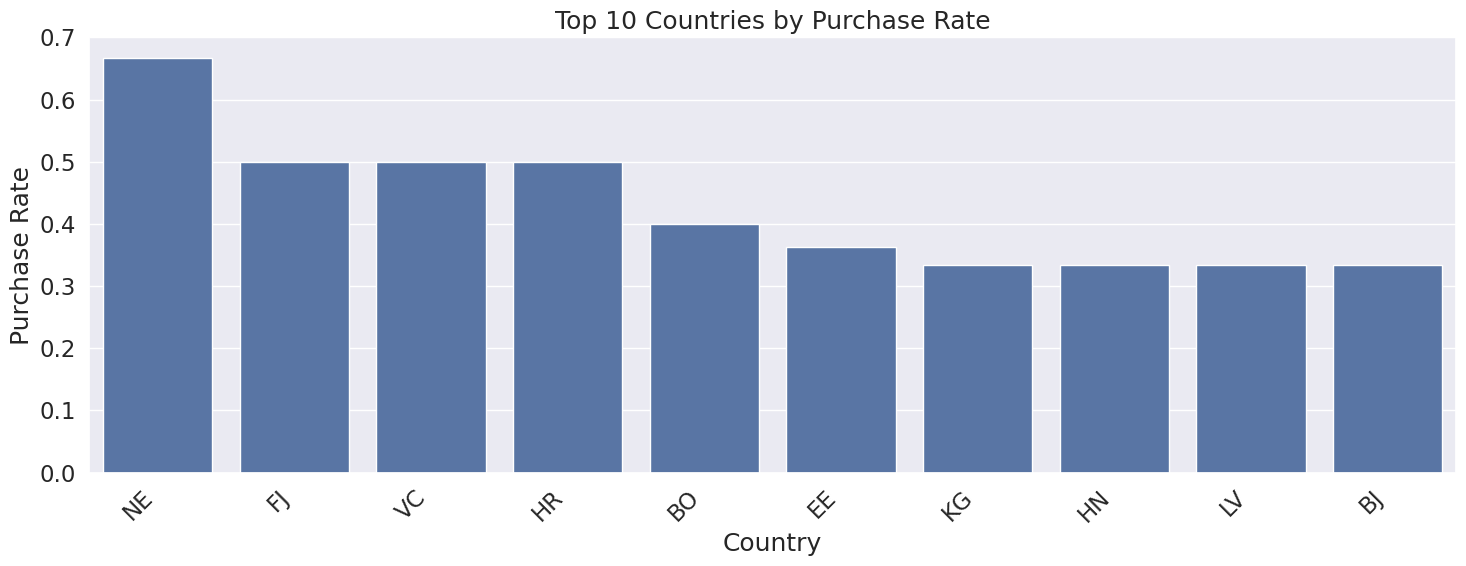

In [ ]:
# Numerical features visualization (Box Plots against 'purchased')
numerical_cols = ['days_on_platform', 'minutes_watched', 'courses_started',
                  'practice_exams_passed', 'minutes_spent_on_exams']

fig, axes = plt.subplots(3, 2, figsize=(18, 18))
axes = axes.flatten() # Flatten the 2x3 array of axes for easy iteration

for i, col in enumerate(numerical_cols):
    sns.boxplot(x='purchased', y=col, data=data_no_nulls, ax=axes[i])
    axes[i].set_title(f'Distribution of {col} by Purchase Status')
    axes[i].set_xlabel('Purchased (0=No, 1=Yes)')
    axes[i].set_ylabel(col)

# Hide any unused subplots
for j in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Categorical feature visualization ('student_country')
# First, count plot for overall distribution
plt.figure(figsize=(15, 6))
sns.countplot(y='student_country', data=data_no_nulls, order=data_no_nulls['student_country'].value_counts().index[:10]) # Top 10 countries
plt.title('Top 10 Student Countries')
plt.xlabel('Count')
plt.ylabel('Country')
plt.show()

# Second, purchase rate per country
country_purchase_rate = data_no_nulls.groupby('student_country')['purchased'].mean().sort_values(ascending=False)
plt.figure(figsize=(15, 6))
sns.barplot(x=country_purchase_rate.index[:10], y=country_purchase_rate.values[:10]) # Top 10 purchase rates
plt.title('Top 10 Countries by Purchase Rate')
plt.xlabel('Country')
plt.ylabel('Purchase Rate')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


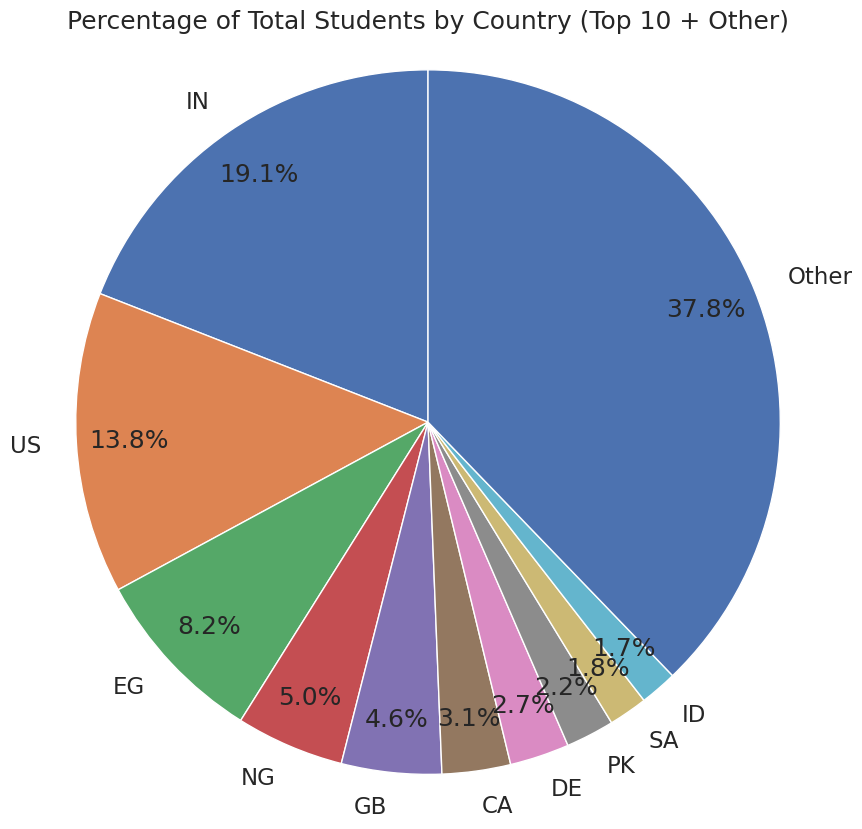

In [ ]:
# Calculate the percentage of students per country
country_counts = data_no_nulls['student_country'].value_counts(normalize=True) * 100

# Select the top 10 countries and group the rest as 'Other'
# This makes the pie chart more readable
top_10_countries = country_counts.head(10)
other_countries_percentage = country_counts.iloc[10:].sum()

# Combine top 10 with 'Other'
pie_data = pd.concat([top_10_countries, pd.Series([other_countries_percentage], index=['Other'])])

# Create the pie chart
plt.figure(figsize=(10, 10))
plt.pie(pie_data, labels=pie_data.index, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
plt.title('Percentage of Total Students by Country (Top 10 + Other)')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


# EDA (3): Checking Balanced/Imbalanced Data

Distribution of 'purchased' variable:
purchased
0    90.786338
1     9.213662
Name: proportion, dtype: float64


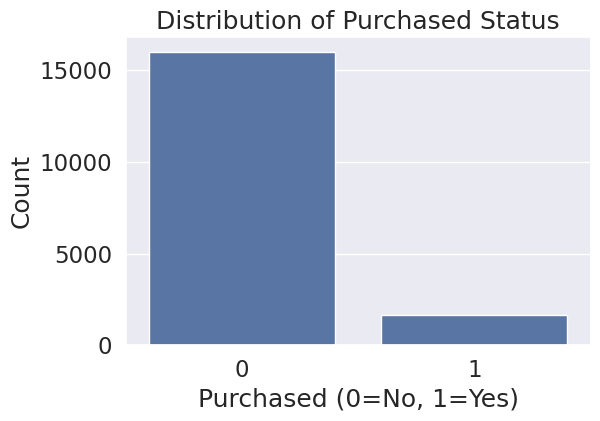

In [ ]:
# Checking for imbalance in the target variable 'purchased'
print("Distribution of 'purchased' variable:")
print(data_no_nulls['purchased'].value_counts(normalize=True) * 100)

# Visualize the distribution of the 'purchased' variable
plt.figure(figsize=(6, 4))
sns.countplot(x='purchased', data=data_no_nulls)
plt.title('Distribution of Purchased Status')
plt.xlabel('Purchased (0=No, 1=Yes)')
plt.ylabel('Count')
plt.show()

In [ ]:
# Get the proportions of the target variable
proportions = data_no_nulls['purchased'].value_counts(normalize=True) * 100

# Define a threshold for imbalance (e.g., if the minority class is less than 20%)
imbalance_threshold = 20

# Check if the minority class is below the threshold
if proportions.min() < imbalance_threshold:
    print(f"The target variable 'purchased' is imbalanced. The minority class (purchased=1) makes up {proportions.min():.2f}% of the data.")
else:
    print(f"The target variable 'purchased' is balanced. The minority class (purchased=1) makes up {proportions.min():.2f}% of the data.")


The target variable 'purchased' is imbalanced. The minority class (purchased=1) makes up 9.21% of the data.


# Split & Encoding Data

## Split Data

In [ ]:
# Defining feature variables & target variable
inputs = data_no_nulls.drop(['purchased'],axis=1)
target = data_no_nulls['purchased']

In [ ]:
# Splitting the data into train and test sets, ensuring balanced classes with stratification
x_train, x_test, y_train, y_test = train_test_split(inputs,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=365,
                                                    stratify = target)

In [ ]:
# Display the first 5 rows of the DataFrame for preview
x_train.head()

,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_passed,minutes_spent_on_exams
5718,IN,218,1.6,2,0,0.0
3119,IN,263,75.5,1,0,0.0
5440,LK,222,44.4,1,0,0.0
11828,TR,97,2.6,1,0,0.0
8454,KR,162,1.0,1,0,0.0


## Encoding Data

In [ ]:
# Initializing an ordinal encoder for categorical variables
enc = OrdinalEncoder(handle_unknown = 'use_encoded_value',
                     unknown_value = 170);

In [ ]:
# Encoding the 'student_country' column in the training and testing datasets
# and storing the encoded variable in a new column called 'student_country_enc'
x_train['student_country_enc'] = enc.fit_transform(x_train['student_country'].to_numpy().reshape(-1, 1));
x_test['student_country_enc'] = enc.transform(x_test['student_country'].to_numpy().reshape(-1, 1));

# Dropping the original 'student_country' column after encoding
x_train = x_train.drop('student_country', axis = 1)
x_test = x_test.drop('student_country', axis = 1)

# Displaying the first five rows of the encoded training dataset
x_train.head()

,days_on_platform,minutes_watched,courses_started,practice_exams_passed,minutes_spent_on_exams,student_country_enc
5718,218,1.6,2,0,0.0,69.0
3119,263,75.5,1,0,0.0,69.0
5440,222,44.4,1,0,0.0,84.0
11828,97,2.6,1,0,0.0,147.0
8454,162,1.0,1,0,0.0,80.0


In [ ]:
# We use the np.asarray() method to ensure data type consistency and compatibility.
# y_train values are converted to integers and x_train values are converted to floating-point numbers.

x_train_array = np.asarray(x_train, dtype = 'float')
y_train_array = np.asarray(y_train, dtype = 'int')

x_test_array = np.asarray(x_test, dtype = 'float')
y_test_array = np.asarray(y_test, dtype = 'int')

# Data Modelling

## Logistic Regression Model

### Logistic Regression

Optimization terminated successfully.
         Current function value: 0.153158
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                14100
Model:                          Logit   Df Residuals:                    14094
Method:                           MLE   Df Model:                            5
Date:                Sun, 07 Dec 2025   Pseudo R-squ.:                  0.5018
Time:                        04:03:08   Log-Likelihood:                -2159.5
converged:                       True   LL-Null:                       -4334.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0691      0.002    -31.912      0.000      -0.073      -0.065
x2             0.0144      0

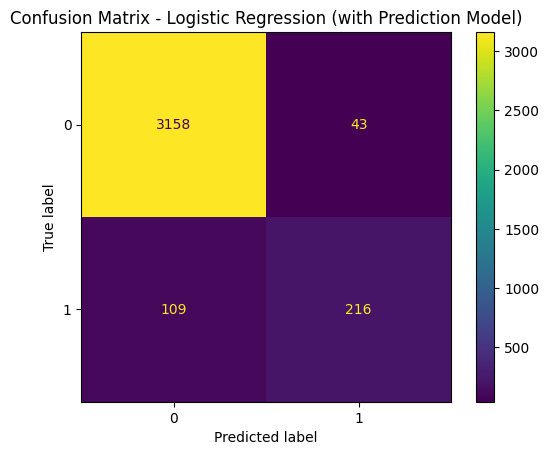

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3201
           1       0.83      0.66      0.74       325

    accuracy                           0.96      3526
   macro avg       0.90      0.83      0.86      3526
weighted avg       0.95      0.96      0.95      3526

ROC AUC: 0.8256


In [ ]:
# Creating a logistic regression model using the sm.Logit function
log_reg = sm.Logit(y_train_array, x_train_array)

# Fitting the model to the training data
log_reg_results = log_reg.fit()

# Displaying a summary of the model results
print(log_reg_results.summary())

# Generating predictions on the test set and rounding the predictions to nearest integer (0 or 1)
y_test_pred_log_reg = [round(log_reg_results.predict(x_test_array)[i], 0)
                       for i in range(len(y_test_array))]

# Resetting any modifications to the plotting context made via seaborn
sns.reset_orig()

# Displaying the confusion matrix from the model's predictions;
ConfusionMatrixDisplay.from_predictions(
    y_test_array, y_test_pred_log_reg,
    cmap = 'viridis'
);

plt.title('Confusion Matrix - Logistic Regression (with Prediction Model)')
plt.show()

# Print the classification report
print(classification_report(y_test_array, y_test_pred_log_reg))

#Calculating the ROC AUC score
auc_score = roc_auc_score(y_test_array, y_test_pred_log_reg)
print(f"ROC AUC: {auc_score:.4f}")

### Logistic Regression (SMOTE)

Optimization terminated successfully.
         Current function value: 0.291631
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                25602
Model:                          Logit   Df Residuals:                    25596
Method:                           MLE   Df Model:                            5
Date:                Sun, 07 Dec 2025   Pseudo R-squ.:                  0.5793
Time:                        04:03:17   Log-Likelihood:                -7466.3
converged:                       True   LL-Null:                       -17746.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0473      0.001    -67.021      0.000      -0.049      -0.046
x2             0.0152      0.

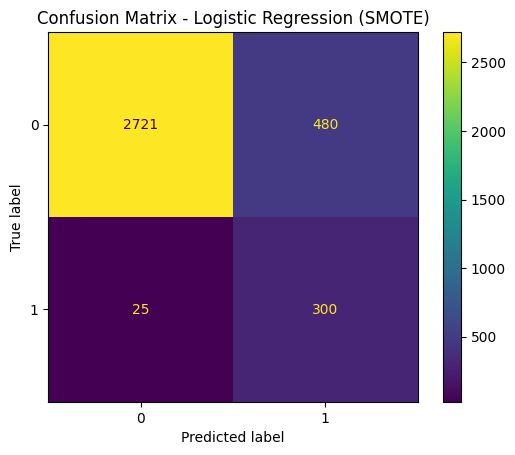

              precision    recall  f1-score   support

           0       0.99      0.85      0.92      3201
           1       0.38      0.92      0.54       325

    accuracy                           0.86      3526
   macro avg       0.69      0.89      0.73      3526
weighted avg       0.94      0.86      0.88      3526

ROC AUC (SMOTE): 0.8866


In [ ]:
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm # Explicitly import statsmodels.api as sm here

# Initialize SMOTE with a distinct name to avoid conflict with statsmodels.api alias 'sm'
smote_sampler = SMOTE(random_state=365)

# Resample the training data
x_train_smote, y_train_smote = smote_sampler.fit_resample(x_train_array, y_train_array)

# Creating a logistic regression model using the sm.Logit function with SMOTE data
log_reg_smote = sm.Logit(y_train_smote, x_train_smote)

# Fitting the model to the SMOTE training data
log_reg_results_smote = log_reg_smote.fit()

# Displaying a summary of the model results
print(log_reg_results_smote.summary())

# Generating predictions on the original test set and rounding the predictions to nearest integer (0 or 1)
y_test_pred_log_reg_smote = [round(log_reg_results_smote.predict(x_test_array)[i], 0)
                               for i in range(len(y_test_array))]

# Resetting any modifications to the plotting context made via seaborn
sns.reset_orig()

# Displaying the confusion matrix from the model's predictions;
ConfusionMatrixDisplay.from_predictions(
    y_test_array, y_test_pred_log_reg_smote,
    cmap = 'viridis'
);

plt.title('Confusion Matrix - Logistic Regression (SMOTE)')
plt.show()

# Print the classification report
print(classification_report(y_test_array, y_test_pred_log_reg_smote))

#Calculating the ROC AUC score
auc_score_smote = roc_auc_score(y_test_array, y_test_pred_log_reg_smote)
print(f"ROC AUC (SMOTE): {auc_score_smote:.4f}")


### Model Insights

**Logistic Regression (without SMOTE)**
*   Accuracy: 0.9569
*   Precision (Class 1): 0.8340
*   Recall (Class 1): 0.6646
*   F1-Score (Class 1): 0.7397
*   ROC AUC: 0.8256

**Logistic Regression (with SMOTE)**
* Accuracy: 0.8568
* Precision (Class 1): 0.3846
* Recall (Class 1): 0.9231
* F1-Score (Class 1): 0.5430
* ROC AUC: 0.8866

**Key Findings and Comparison:**

1. **Accuracy**: The overall accuracy decreased when SMOTE was applied (from 0.9569 to 0.8568). This is a common trade-off, as models on imbalanced data often achieve high accuracy by simply predicting the majority class, which isn't necessarily desirable.

2. **Recall (Class 1 - Purchased)**: This is where SMOTE made the most significant positive impact. The Recall for the minority class (purchased=1) dramatically increased from 0.6646 to 0.9231. This means the model with SMOTE is much better at identifying actual purchasers, catching over 92% of them, compared to about 66% without SMOTE.

3. **Precision (Class 1 - Purchased)**: Conversely, the Precision for the minority class dropped substantially (from 0.8340 to 0.3846) after applying SMOTE. While the SMOTE model identifies most purchasers, a large proportion of its positive predictions are actually false positives. This indicates that while it casts a wider net, it also includes more non-purchasers.

4. **F1-Score (Class 1 - Purchased)**: The F1-Score, which balances precision and recall, decreased from 0.7397 to 0.5430. This highlights the trade-off: despite the high recall, the very low precision pulled the F1-Score down.

5. **ROC AUC**: The ROC AUC score, a robust metric for imbalanced data that measures the model's ability to discriminate between classes, significantly improved from 0.8256 to 0.8866 with SMOTE. This indicates that even with the precision drop, the SMOTE model generally has better separability between the two classes.


**Conclusion for Logistic Regression**:
* Without SMOTE, the model had high overall accuracy and good precision for purchasers, but missed a substantial portion of actual purchasers (lower recall).
* With SMOTE, the Logistic Regression model became much more effective at identifying true purchasers (very high recall), which is often the primary goal in imbalanced classification tasks like marketing.

However, this came at the cost of precision, meaning many non-purchasers were incorrectly flagged as potential purchasers. The improved ROC AUC suggests that the model is better at differentiating the classes overall, making the SMOTE-enhanced Logistic Regression a more suitable choice if identifying as many potential purchasers as possible (high recall) is prioritized.

### Actual vs Prediction

In [ ]:
import pandas as pd

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({'Actual_Y': y_test_array, 'Predicted_Y_LogReg': y_test_pred_log_reg})

# Display the first few rows of the comparison table
print("Comparison of Actual vs. Predicted values (Logistic Regression):")
display(comparison_df.head())

# Optionally, you can also look at the value counts for discrepancies
print("\nValue counts for Actual_Y:")
display(comparison_df['Actual_Y'].value_counts())
print("\nValue counts for Predicted_Y_LogReg:")
display(comparison_df['Predicted_Y_LogReg'].value_counts())


Comparison of Actual vs. Predicted values (Logistic Regression):


,Actual_Y,Predicted_Y_LogReg
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0



Value counts for Actual_Y:


,count
Actual_Y,
0,3201
1,325



Value counts for Predicted_Y_LogReg:


,count
Predicted_Y_LogReg,
0.0,3267
1.0,259


In [ ]:
import pandas as pd

# Create a DataFrame for the x_test features (first 30 rows)
x_test_df = pd.DataFrame(x_test_array, columns=x_test.columns).head(30)

# Create a DataFrame for actual and predicted y values (first 30 rows)
y_comparison_df = pd.DataFrame({
    'Actual_Y': y_test_array,
    'Predicted_Y_LogReg': y_test_pred_log_reg,
    'Predicted_Y_LogReg_SMOTE': y_test_pred_log_reg_smote
}).head(30)

# Reset index of y_comparison_df to align with x_test_df indices (which are 0-based for the head() result)
x_test_df = x_test_df.reset_index(drop=True)
y_comparison_df = y_comparison_df.reset_index(drop=True)

# Concatenate the features and the actual/predicted values
full_comparison_df = pd.concat([x_test_df, y_comparison_df], axis=1)

# Display the first 30 rows of the comprehensive comparison table
print("Comprehensive comparison of features, actual Y, and predicted Y for Logistic Regression models:")
display(full_comparison_df)


Comprehensive comparison of features, actual Y, and predicted Y for Logistic Regression models:


,days_on_platform,minutes_watched,courses_started,practice_exams_passed,minutes_spent_on_exams,student_country_enc,Actual_Y,Predicted_Y_LogReg,Predicted_Y_LogReg_SMOTE
0,284.0,0.7,1.0,0.0,0.00,68.0,0,0.0,0.0
1,66.0,65.7,2.0,0.0,0.00,46.0,0,0.0,0.0
2,48.0,65.4,4.0,0.0,0.00,12.0,0,0.0,1.0
3,219.0,1.4,1.0,0.0,0.00,152.0,0,0.0,0.0
4,39.0,0.3,1.0,0.0,0.00,46.0,0,0.0,0.0
5,0.0,1.4,1.0,0.0,0.00,152.0,1,1.0,1.0
6,31.0,0.1,1.0,0.0,0.00,123.0,0,0.0,1.0
7,277.0,0.5,1.0,0.0,0.00,108.0,0,0.0,0.0
8,70.0,1.2,1.0,0.0,0.00,46.0,0,0.0,0.0
9,66.0,216.1,2.0,3.0,16.53,46.0,0,0.0,1.0


In [ ]:
# Filter rows where predictions differ between the two models
diff_predictions_df = full_comparison_df[full_comparison_df['Predicted_Y_LogReg'] != full_comparison_df['Predicted_Y_LogReg_SMOTE']]

print("Rows where predictions differ between Logistic Regression (without SMOTE) and (with SMOTE):")
display(diff_predictions_df)


Rows where predictions differ between Logistic Regression (without SMOTE) and (with SMOTE):


,days_on_platform,minutes_watched,courses_started,practice_exams_passed,minutes_spent_on_exams,student_country_enc,Actual_Y,Predicted_Y_LogReg,Predicted_Y_LogReg_SMOTE
2,48.0,65.4,4.0,0.0,0.00,12.0,0,0.0,1.0
6,31.0,0.1,1.0,0.0,0.00,123.0,0,0.0,1.0
9,66.0,216.1,2.0,3.0,16.53,46.0,0,0.0,1.0
11,19.0,1.7,1.0,0.0,0.00,66.0,1,0.0,1.0
14,6.0,3.6,1.0,0.0,0.00,47.0,0,0.0,1.0
18,37.0,16.6,1.0,0.0,0.00,133.0,0,0.0,1.0
19,7.0,25.0,2.0,0.0,0.00,126.0,1,0.0,1.0
24,35.0,32.0,1.0,0.0,0.00,70.0,0,0.0,1.0


**Key Observation from the Output**: For every row in this diff_predictions_df table, you'll notice a consistent pattern: the Predicted_Y_LogReg (without SMOTE) is 0.0 (not purchased), while Predicted_Y_LogReg_SMOTE is 1.0 (purchased).

**Interpretation**: This consistent pattern is a direct illustration of SMOTE's impact on the model, especially in the context of an imbalanced dataset:

* **Original Model's Bias**: The Logistic Regression model without SMOTE (as shown by Predicted_Y_LogReg = 0.0) tended to be conservative and predicted 0 (not purchased) for these instances. Given the high proportion of '0's in the original dataset, the model was likely optimized to achieve high accuracy by predicting the majority class more often.

* **SMOTE's Influence**: The Logistic Regression model with SMOTE (as shown by Predicted_Y_LogReg_SMOTE = 1.0) is now predicting 1 (purchased) for these same instances. This happens because SMOTE oversamples the minority class during training, making the model more sensitive to the characteristics of the minority class. As a result, it becomes more willing to predict a '1' even for cases it might have previously classified as '0'.

* **Impact on Recall vs. Precision**: This change explains the trade-off we observed earlier: the SMOTE model significantly increased Recall for the minority class (it's catching more actual '1's that the non-SMOTE model missed), but it also decreased Precision (it's now predicting more '1's, some of which might be incorrect '0's).

## K-Nearest Neighbors (KNN) Model

### KNN

--- The Grid Search Object on the training data ---
<bound method BaseSearchCV.fit of GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 51),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')>
--- The Best Parameters and The Corresponding Score ---
{'n_neighbors': 7, 'weights': 'uniform'} 0.9599290780141843
--- The Best Estimator (model with optimal parameters) ---
KNeighborsClassifier(n_neighbors=7)


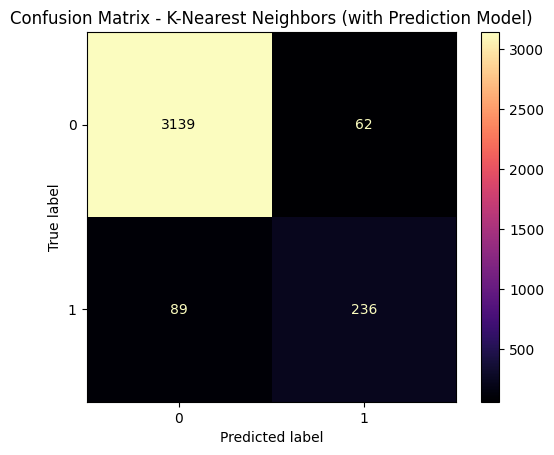

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3201
           1       0.79      0.73      0.76       325

    accuracy                           0.96      3526
   macro avg       0.88      0.85      0.87      3526
weighted avg       0.96      0.96      0.96      3526

ROC AUC: 0.8534


In [ ]:
# Define the parameter grid for the grid search
parameters_knn = {'n_neighbors':range(1, 51),
                  'weights':['uniform', 'distance']}

# Initialize a GridSearchCV object with KNeighborsClassifier estimator
# and accuracy as the scoring metric
grid_search_knn = GridSearchCV(estimator = KNeighborsClassifier(),
                               param_grid = parameters_knn,
                               scoring = 'accuracy')

# Fit the grid search object on the training data
print("--- The Grid Search Object on the training data ---")
grid_search_knn.fit(x_train_array, y_train_array)
print(grid_search_knn.fit)

# Display the best parameters and the corresponding score
print("--- The Best Parameters and The Corresponding Score ---")
print(grid_search_knn.best_params_, grid_search_knn.best_score_)

# Store the best estimator (model with optimal parameters) in knn_clf
print("--- The Best Estimator (model with optimal parameters) ---")
knn_clf = grid_search_knn.best_estimator_
print(knn_clf)

# Predict the target variable for the test dataset using the optimal model
y_test_pred_knn = knn_clf.predict(x_test_array)

# Reset seaborn settings to default
sns.reset_orig()

# Display the confusion matrix using seaborn;
# Set the labels to the classes of the model;
ConfusionMatrixDisplay.from_predictions(
    y_test_array, y_test_pred_knn,
    labels = knn_clf.classes_,
    cmap = 'magma'
);

plt.title('Confusion Matrix - K-Nearest Neighbors (with Prediction Model)')
plt.show()

# Print the classification report, providing an overview of how well the classifier has performed
print(classification_report(y_test_array,
                            y_test_pred_knn,
                            target_names = ['0', '1']))

#Calculating the ROC AUC score
auc_score = roc_auc_score(y_test_array, y_test_pred_knn)
print(f"ROC AUC: {auc_score:.4f}")

### KNN (SMOTE)

Best parameters for KNN with SMOTE: {'n_neighbors': 1, 'weights': 'uniform'}
Best accuracy score for KNN with SMOTE: 0.9560191643477836


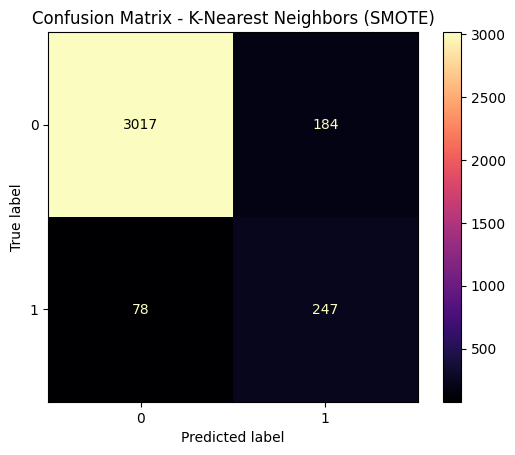

              precision    recall  f1-score   support

           0       0.97      0.94      0.96      3201
           1       0.57      0.76      0.65       325

    accuracy                           0.93      3526
   macro avg       0.77      0.85      0.81      3526
weighted avg       0.94      0.93      0.93      3526

ROC AUC (KNN with SMOTE): 0.8513


In [ ]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote_sampler_knn = SMOTE(random_state=365)

# Resample the training data for KNN
x_train_smote_knn, y_train_smote_knn = smote_sampler_knn.fit_resample(x_train_array, y_train_array)

# Define the parameter grid for the grid search (reusing previous parameters_knn)
# parameters_knn = {'n_neighbors':range(1, 51),
#                   'weights':['uniform', 'distance']}
# Assuming parameters_knn is still defined from cell '7OdutCpKmt5q'

# Initialize a GridSearchCV object with KNeighborsClassifier estimator
# and accuracy as the scoring metric
grid_search_knn_smote = GridSearchCV(estimator = KNeighborsClassifier(),
                                   param_grid = parameters_knn, # Using the previously defined parameters
                                   scoring = 'accuracy')

# Fit the grid search object on the SMOTE-resampled training data
grid_search_knn_smote.fit(x_train_smote_knn, y_train_smote_knn)

# Display the best parameters and the corresponding score
print(f"Best parameters for KNN with SMOTE: {grid_search_knn_smote.best_params_}")
print(f"Best accuracy score for KNN with SMOTE: {grid_search_knn_smote.best_score_}")

# Store the best estimator (model with optimal parameters) in knn_clf_smote
knn_clf_smote = grid_search_knn_smote.best_estimator_

# Predict the target variable for the test dataset using the optimal model
y_test_pred_knn_smote = knn_clf_smote.predict(x_test_array)

# Reset seaborn settings to default
sns.reset_orig()

# Display the confusion matrix using seaborn;
ConfusionMatrixDisplay.from_predictions(
    y_test_array, y_test_pred_knn_smote,
    labels = knn_clf_smote.classes_,
    cmap = 'magma'
);

plt.title('Confusion Matrix - K-Nearest Neighbors (SMOTE)')
plt.show()

# Print the classification report, providing an overview of how well the classifier has performed
print(classification_report(y_test_array,
                            y_test_pred_knn_smote,
                            target_names = ['0', '1']))

#Calculating the ROC AUC score
auc_score_knn_smote = roc_auc_score(y_test_array, y_test_pred_knn_smote)
print(f"ROC AUC (KNN with SMOTE): {auc_score_knn_smote:.4f}")


### Model Insights

**K-Nearest Neighbors (without SMOTE)**
* Accuracy: 0.9572
* Precision (Class 1): 0.7919
* Recall (Class 1): 0.7262
* F1-Score (Class 1): 0.7576
* ROC AUC: 0.8534

**K-Nearest Neighbors (with SMOTE)**
* Accuracy: 0.9257
* Precision (Class 1): 0.5731
* Recall (Class 1): 0.7600
* F1-Score (Class 1): 0.6534
* ROC AUC: 0.8513

**Key Findings and Comparison:**
1. **Accuracy**: The overall accuracy decreased when SMOTE was applied (from 0.9572 to 0.9257). Similar to Logistic Regression, models often achieve high accuracy on imbalanced data by favoring the majority class.
2. **Recall (Class 1 - Purchased)**: SMOTE provided a slight increase in Recall for the minority class (purchased=1) from 0.7262 to 0.7600. This indicates that the SMOTE-enhanced KNN model was slightly better at identifying actual purchasers.
3. **Precision (Class 1 - Purchased)**: The Precision for the minority class dropped noticeably (from 0.7919 to 0.5731) after applying SMOTE. This suggests that while the SMOTE model caught more actual purchasers, it also made more false positive predictions.
4. **F1-Score (Class 1 - Purchased)**: The F1-Score, which balances precision and recall, decreased from 0.7576 to 0.6534. The lower precision, despite the slight recall gain, led to a reduced F1-Score.
5. **ROC AUC**: The ROC AUC score remained relatively stable, showing a very minor decrease from 0.8534 to 0.8513 with SMOTE. This indicates that while SMOTE shifted the balance of predictions (improving recall at the cost of precision), it didn't significantly alter the model's overall ability to discriminate between the classes.

**Conclusion for K-Nearest Neighbors**:
* Without SMOTE, the KNN model had good overall accuracy and decent precision for purchasers, but its recall was moderate.
* With SMOTE, the KNN model showed a marginal improvement in recall for identifying purchasers, but this came at a more significant cost to precision and a slight decrease in overall F1-score and ROC AUC.

For KNN, the benefits of SMOTE were less pronounced than for Logistic Regression, and the trade-offs were more noticeable.

### Actual vs Prediction

In [ ]:
import pandas as pd

# Create a DataFrame for the x_test features (first 30 rows)
x_test_df_knn = pd.DataFrame(x_test_array, columns=x_test.columns).head(30)

# Create a DataFrame for actual and predicted y values for KNN (first 30 rows)
y_comparison_df_knn = pd.DataFrame({
    'Actual_Y': y_test_array,
    'Predicted_Y_KNN': y_test_pred_knn,
    'Predicted_Y_KNN_SMOTE': y_test_pred_knn_smote
}).head(30)

# Reset index of y_comparison_df_knn to align with x_test_df_knn indices
x_test_df_knn = x_test_df_knn.reset_index(drop=True)
y_comparison_df_knn = y_comparison_df_knn.reset_index(drop=True)

# Concatenate the features and the actual/predicted values
full_comparison_df_knn = pd.concat([x_test_df_knn, y_comparison_df_knn], axis=1)

# Display the first 30 rows of the comprehensive comparison table for KNN models
print("Comprehensive comparison of features, actual Y, and predicted Y for KNN models:")
display(full_comparison_df_knn)


Comprehensive comparison of features, actual Y, and predicted Y for KNN models:


,days_on_platform,minutes_watched,courses_started,practice_exams_passed,minutes_spent_on_exams,student_country_enc,Actual_Y,Predicted_Y_KNN,Predicted_Y_KNN_SMOTE
0,284.0,0.7,1.0,0.0,0.00,68.0,0,0,0
1,66.0,65.7,2.0,0.0,0.00,46.0,0,0,0
2,48.0,65.4,4.0,0.0,0.00,12.0,0,0,0
3,219.0,1.4,1.0,0.0,0.00,152.0,0,0,0
4,39.0,0.3,1.0,0.0,0.00,46.0,0,0,0
5,0.0,1.4,1.0,0.0,0.00,152.0,1,1,1
6,31.0,0.1,1.0,0.0,0.00,123.0,0,0,0
7,277.0,0.5,1.0,0.0,0.00,108.0,0,0,0
8,70.0,1.2,1.0,0.0,0.00,46.0,0,0,0
9,66.0,216.1,2.0,3.0,16.53,46.0,0,0,0


In [ ]:
# Identify rows where either KNN model misclassified
misclassifications_knn = full_comparison_df_knn[
    (full_comparison_df_knn['Actual_Y'] != full_comparison_df_knn['Predicted_Y_KNN']) |
    (full_comparison_df_knn['Actual_Y'] != full_comparison_df_knn['Predicted_Y_KNN_SMOTE'])
]

print("Rows with misclassifications by either KNN model (first 30 rows of test set):")
display(misclassifications_knn)


Rows with misclassifications by either KNN model (first 30 rows of test set):


,days_on_platform,minutes_watched,courses_started,practice_exams_passed,minutes_spent_on_exams,student_country_enc,Actual_Y,Predicted_Y_KNN,Predicted_Y_KNN_SMOTE
11,19.0,1.7,1.0,0.0,0.0,66.0,1,0,0
14,6.0,3.6,1.0,0.0,0.0,47.0,0,0,1
19,7.0,25.0,2.0,0.0,0.0,126.0,1,0,0
25,2.0,2.8,1.0,0.0,0.0,152.0,0,1,1


The misclassifications_knn table focuses on the instances (from the first 30 rows of the test set) where there was a discrepancy between the Actual_Y and at least one of the KNN models' predictions (Predicted_Y_KNN or Predicted_Y_KNN_SMOTE).

Here's what these differing predictions highlight:

1. **False Negatives (Missed Purchases)**:

    * **Instances**: Rows 11 and 19 show Actual_Y = 1 (purchased), but both Predicted_Y_KNN = 0 and Predicted_Y_KNN_SMOTE = 0. This means both KNN models, even with SMOTE, failed to identify these actual purchasers. These are False Negatives, which are critical in a business context where identifying all potential customers is important.
    * **Finding**: For these specific cases, SMOTE did not help the KNN model in correctly classifying the minority class. This suggests that these instances might be particularly difficult to classify, or perhaps their features don't strongly align with the synthetic samples generated by SMOTE.
2. **False Positives (Incorrectly Predicted Purchases)**:
    * **Instance (Row 14)**: Actual_Y = 0 (not purchased), Predicted_Y_KNN = 0 (correct), but Predicted_Y_KNN_SMOTE = 1. Here, the KNN model without SMOTE was correct, but the SMOTE-enhanced model incorrectly predicted a purchase. This is a False Positive.
    * **Instance (Row 25)**: Actual_Y = 0 (not purchased), but both Predicted_Y_KNN = 1 and Predicted_Y_KNN_SMOTE = 1 incorrectly predicted a purchase. Both models here produced False Positives.
    * **Finding**: The false positive in row 14 by the SMOTE model is a typical trade-off. SMOTE makes the model more sensitive to the minority class, increasing recall, but sometimes at the cost of precision by misclassifying majority class instances as minority. In row 25, both models struggle, suggesting that for this specific data point, its features might be ambiguous or very close to the decision boundary for both models.

**Overall Findings from Actual vs. Prediction for KNN**:
* **SMOTE's Limited Impact on Specific KNN Errors**: Unlike Logistic Regression where SMOTE often flipped predictions from 0 to 1 for actual positives, for KNN, its impact on correcting specific misclassifications (especially false negatives) within this small sample of differing rows seems limited. In rows 11 and 19, both versions still missed the purchase.
* **Trade-off Confirmation**: The false positive in row 14 by the SMOTE model is a clear illustration of the precision-recall trade-off. SMOTE aims to reduce false negatives (increase recall) but can sometimes lead to an increase in false positives (decrease precision).
* **Model Consistency in Some Errors**: For row 25, both KNN models made the same error (false positive), suggesting that this instance might be inherently difficult for the KNN algorithm, regardless of SMOTE.

In essence, while the aggregate metrics showed a slight increase in recall for KNN with SMOTE, this granular view helps us understand that this improvement might not be uniform across all misclassified instances, and the cost in precision can be seen at an individual data point level.

## Support Vector Machines (SVM) Model

### SVM

In [ ]:
# Create an instance of the MinMaxScaler. This will normalize the features to a range between -1 and 1
scaling = MinMaxScaler(feature_range=(-1,1))

# Fit the scaler to the training data and transform it
x_train_array_svc = scaling.fit_transform(x_train_array)

# Use the same scaler to transform the test data
x_test_array_svc = scaling.transform(x_test_array)

# Set up a dictionary of parameters for grid search
parameters_svc = {'kernel':['linear', 'poly', 'rbf'],
                  'C':range(1, 11),
                  'gamma': ['scale', 'auto']}

# Initialize a GridSearchCV object with the SVC estimator and accuracy as the scoring metric
grid_search_svc = GridSearchCV(estimator = SVC(),
                               param_grid = parameters_svc,
                               scoring = 'accuracy')

# Note: Fitting process can take some time due to the number of combinations
grid_search_svc.fit(x_train_array_svc, y_train_array)

GridSearchCV(estimator=SVC(),
             param_grid={'C': range(1, 11), 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring='accuracy')

In [ ]:
# Display the best model obtained from the grid search
grid_search_svc.best_estimator_

# Store the best estimator (model with optimal parameters) in svc_clf
svc_clf = grid_search_svc.best_estimator_
print(svc_clf)

SVC(C=6, kernel='poly')


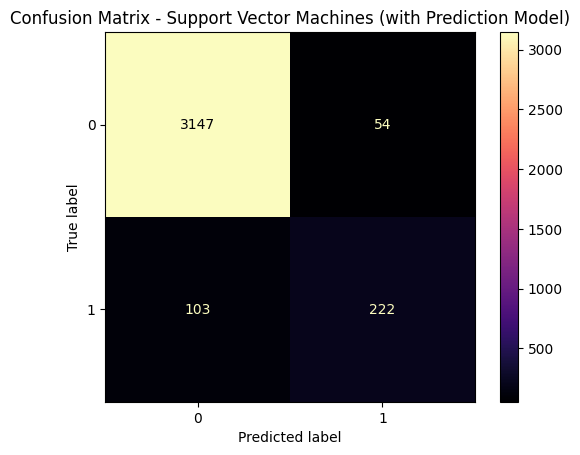

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3201
           1       0.80      0.68      0.74       325

    accuracy                           0.96      3526
   macro avg       0.89      0.83      0.86      3526
weighted avg       0.95      0.96      0.95      3526

ROC AUC: 0.8331


In [ ]:
# Use the best estimator to predict the target variable for the test dataset
y_test_pred_svc = svc_clf.predict(x_test_array_svc)

# Reset seaborn settings to default
sns.reset_orig()

# Display the confusion matrix using seaborn;
ConfusionMatrixDisplay.from_predictions(
    y_test_array, y_test_pred_svc,
    labels = svc_clf.classes_,
    cmap = 'magma'
);

plt.title('Confusion Matrix - Support Vector Machines (with Prediction Model)')
plt.show()

# Print the classification report to get precision, recall, f1-score, and support for each class
print(classification_report(y_test_array,
                            y_test_pred_svc,
                            target_names = ['0', '1']))

#Calculating the ROC AUC score
auc_score = roc_auc_score(y_test_array, y_test_pred_svc)
print(f"ROC AUC: {auc_score:.4f}")

### SVM (SMOTE)

Fitting GridSearchCV for SVM with SMOTE (faster version)...
GridSearchCV fitting complete.
Best estimator for SVM with SMOTE: SVC(C=10, random_state=365)


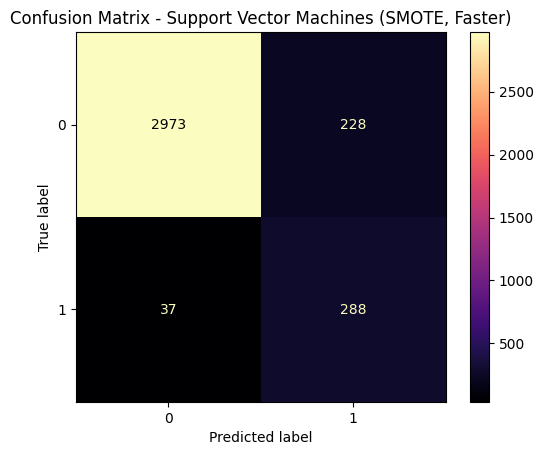

              precision    recall  f1-score   support

           0       0.99      0.93      0.96      3201
           1       0.56      0.89      0.68       325

    accuracy                           0.92      3526
   macro avg       0.77      0.91      0.82      3526
weighted avg       0.95      0.92      0.93      3526

ROC AUC (SVM with SMOTE, Faster): 0.9075


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize SMOTE
smote_sampler_svc = SMOTE(random_state=365)

# Resample the training data for SVC
x_train_smote_svc, y_train_smote_svc = smote_sampler_svc.fit_resample(x_train_array, y_train_array)

# Create an instance of the MinMaxScaler. This will normalize the features to a range between -1 and 1
scaling_smote = MinMaxScaler(feature_range=(-1,1))

# Fit the scaler to the SMOTE-resampled training data and transform it
x_train_smote_svc_scaled = scaling_smote.fit_transform(x_train_smote_svc)

# Use the same scaler to transform the original test data
x_test_array_svc_scaled = scaling_smote.transform(x_test_array)

# Set up a dictionary of parameters for grid search (reduced for faster execution)
parameters_svc_fast = {
    'kernel':['rbf'], # Focusing on 'rbf' as it's common and often performs well
    'C':[1, 10], # Reduced range for C
    'gamma': ['scale', 'auto'] # Keep scale and auto
}

# Initialize a GridSearchCV object with the SVC estimator and accuracy as the scoring metric
grid_search_svc_smote_fast = GridSearchCV(estimator = SVC(random_state=365),
                                          param_grid = parameters_svc_fast,
                                          scoring = 'accuracy',
                                          cv=3, # Reduced cross-validation folds for speed
                                          n_jobs=-1) # Use all available cores for parallel processing

# Fit the grid search object on the SMOTE-resampled and scaled training data
print("Fitting GridSearchCV for SVM with SMOTE (faster version)...")
grid_search_svc_smote_fast.fit(x_train_smote_svc_scaled, y_train_smote_svc)
print("GridSearchCV fitting complete.")

# Display the best model obtained from the grid search
print(f"Best estimator for SVM with SMOTE: {grid_search_svc_smote_fast.best_estimator_}")

# Store the best estimator (model with optimal parameters) in svc_clf_smote
svc_clf_smote = grid_search_svc_smote_fast.best_estimator_

# Use the best estimator to predict the target variable for the test dataset
y_test_pred_svc_smote = svc_clf_smote.predict(x_test_array_svc_scaled)

# Reset seaborn settings to default
sns.reset_orig()

# Display the confusion matrix using seaborn;
ConfusionMatrixDisplay.from_predictions(
    y_test_array, y_test_pred_svc_smote,
    labels = svc_clf_smote.classes_,
    cmap = 'magma'
);

plt.title('Confusion Matrix - Support Vector Machines (SMOTE, Faster)')
plt.show()

# Print the classification report to get precision, recall, f1-score, and support for each class
print(classification_report(y_test_array,
                            y_test_pred_svc_smote,
                            target_names = ['0', '1']))

#Calculating the ROC AUC score
auc_score_svc_smote = roc_auc_score(y_test_array, y_test_pred_svc_smote)
print(f"ROC AUC (SVM with SMOTE, Faster): {auc_score_svc_smote:.4f}")


### Model Insights

**Support Vector Machines (without SMOTE)**
* Accuracy: 0.9555
* Precision (Class 1): 0.8043
* Recall (Class 1): 0.6831
* F1-Score (Class 1): 0.7388
* ROC AUC: 0.8331

**Support Vector Machines (with SMOTE)**
* Accuracy: 0.9248
* Precision (Class 1): 0.5581
* Recall (Class 1): 0.8862
* F1-Score (Class 1): 0.6849
* ROC AUC: 0.9075

**Key Findings and Comparison**:
1. **Accuracy**: The overall accuracy decreased when SMOTE was applied (from 0.9555 to 0.9248). This is a common pattern when addressing class imbalance, as the model becomes less biased towards the majority class.
2. **Recall (Class 1 - Purchased)**: This is where SMOTE had a substantial positive impact for SVM. The Recall for the minority class (purchased=1) significantly increased from 0.6831 to 0.8862. This means the SVM model with SMOTE is much better at identifying actual purchasers, catching nearly 89% of them, compared to about 68% without SMOTE.
3. **Precision (Class 1 - Purchased)**: The Precision for the minority class dropped noticeably (from 0.8043 to 0.5581) after applying SMOTE. While the SMOTE-enhanced SVM model caught a lot more purchasers, it also increased the number of false positives (instances where it predicted a purchase but there wasn't one).
4. **F1-Score (Class 1 - Purchased)**: The F1-Score, which balances precision and recall, decreased from 0.7388 to 0.6849. Despite the large gain in recall, the significant drop in precision pulled the F1-Score down slightly.
5. **ROC AUC**: The ROC AUC score saw a substantial improvement from 0.8331 to 0.9075 with SMOTE. This is a crucial finding, as ROC AUC is a robust metric for imbalanced datasets and indicates that the SVM model with SMOTE has the strongest ability among all models tested to discriminate between the two classes.

**Conclusion for Support Vector Machines**:
* Without SMOTE, the SVM model had good accuracy and precision but missed a notable portion of actual purchasers.
* With SMOTE, the SVM model became highly effective at identifying true purchasers (very high recall), which is often the primary objective in such business contexts.

Although this came with a reduction in precision, the significant improvement in ROC AUC to 0.9075 indicates that the SMOTE-enhanced SVM model is excellent at distinguishing between purchasers and non-purchasers, making it a very strong candidate if maximizing the identification of potential customers is the priority.

### Actual vs Prediction

In [ ]:
import pandas as pd

# Create a DataFrame for the x_test features (first 30 rows)
x_test_df_svc = pd.DataFrame(x_test_array, columns=x_test.columns).head(30)

# Create a DataFrame for actual and predicted y values for SVM (first 30 rows)
y_comparison_df_svc = pd.DataFrame({
    'Actual_Y': y_test_array,
    'Predicted_Y_SVC': y_test_pred_svc,
    'Predicted_Y_SVC_SMOTE': y_test_pred_svc_smote
}).head(30)

# Reset index of y_comparison_df_svc to align with x_test_df_svc indices
x_test_df_svc = x_test_df_svc.reset_index(drop=True)
y_comparison_df_svc = y_comparison_df_svc.reset_index(drop=True)

# Concatenate the features and the actual/predicted values
full_comparison_df_svc = pd.concat([x_test_df_svc, y_comparison_df_svc], axis=1)

# Display the first 30 rows of the comprehensive comparison table for SVM models
print("Comprehensive comparison of features, actual Y, and predicted Y for SVM models:")
display(full_comparison_df_svc)


Comprehensive comparison of features, actual Y, and predicted Y for SVM models:


,days_on_platform,minutes_watched,courses_started,practice_exams_passed,minutes_spent_on_exams,student_country_enc,Actual_Y,Predicted_Y_SVC,Predicted_Y_SVC_SMOTE
0,284.0,0.7,1.0,0.0,0.00,68.0,0,0,0
1,66.0,65.7,2.0,0.0,0.00,46.0,0,0,0
2,48.0,65.4,4.0,0.0,0.00,12.0,0,0,0
3,219.0,1.4,1.0,0.0,0.00,152.0,0,0,0
4,39.0,0.3,1.0,0.0,0.00,46.0,0,0,0
5,0.0,1.4,1.0,0.0,0.00,152.0,1,1,1
6,31.0,0.1,1.0,0.0,0.00,123.0,0,0,0
7,277.0,0.5,1.0,0.0,0.00,108.0,0,0,0
8,70.0,1.2,1.0,0.0,0.00,46.0,0,0,0
9,66.0,216.1,2.0,3.0,16.53,46.0,0,0,0


In [ ]:
# Identify rows where either SVM model misclassified
misclassifications_svc = full_comparison_df_svc[
    (full_comparison_df_svc['Actual_Y'] != full_comparison_df_svc['Predicted_Y_SVC']) |
    (full_comparison_df_svc['Actual_Y'] != full_comparison_df_svc['Predicted_Y_SVC_SMOTE'])
]

print("Rows with misclassifications by either SVM model (first 30 rows of test set):")
display(misclassifications_svc)


Rows with misclassifications by either SVM model (first 30 rows of test set):


,days_on_platform,minutes_watched,courses_started,practice_exams_passed,minutes_spent_on_exams,student_country_enc,Actual_Y,Predicted_Y_SVC,Predicted_Y_SVC_SMOTE
11,19.0,1.7,1.0,0.0,0.0,66.0,1,0,0
14,6.0,3.6,1.0,0.0,0.0,47.0,0,0,1
25,2.0,2.8,1.0,0.0,0.0,152.0,0,1,1


Let's break down these misclassifications:

1. **False Negatives (Missed Purchases)**:
    * **Instances**: In Row 11, the Actual_Y is 1 (purchased), but both Predicted_Y_SVC (0) and Predicted_Y_SVC_SMOTE (0) incorrectly predicted no purchase. This means both SVM models, even with SMOTE, failed to identify this actual purchaser. This is a False Negative, which is a critical error if the goal is to maximize the identification of potential customers.
    * **Finding**: For this specific case, SMOTE did not help the SVM model in correctly classifying the minority class. This suggests that this instance might be particularly difficult to classify, or its features didn't align strongly enough with the synthetic samples generated by SMOTE.
2. **False Positives (Incorrectly Predicted Purchases)**:
    * **Instance (Row 14)**: The Actual_Y is 0 (not purchased). Predicted_Y_SVC is 0 (correct), but Predicted_Y_SVC_SMOTE is 1 (incorrectly predicted a purchase). Here, the SMOTE-enhanced model made a False Positive.
    * **Instance (Row 25)**: The Actual_Y is 0 (not purchased), but both Predicted_Y_SVC (1) and Predicted_Y_SVC_SMOTE (1) incorrectly predicted a purchase. Both SVM models here produced False Positives.
    * **Finding**: The false positive in Row 14 by the SMOTE model is a typical trade-off. SMOTE aims to increase the model's sensitivity to the minority class (improving recall) but can sometimes lead to an increase in false positives (decreasing precision). In Row 25, both models struggle, suggesting that this particular data point might be ambiguous or very close to the decision boundary for both versions of the SVM model.

**Overall Findings from Actual vs. Prediction for SVM**:
* **SMOTE's Effect on Specific Errors**: Unlike Logistic Regression where SMOTE often flipped predictions from 0 to 1 for actual positives, for SVM in this sample, its impact on correcting false negatives (like in Row 11) was limited. However, it did contribute to a false positive in Row 14 where the non-SMOTE model was correct.
* **Trade-off Confirmation**: The observed false positives (Rows 14 and 25) for the SMOTE-enhanced model illustrate the precision-recall trade-off. While the aggregate metrics showed that SVM with SMOTE achieved the highest ROC AUC and good recall, this granular view highlights that it still makes false positive errors at the individual data point level.
* **Consistent Errors**: For Row 25, both SVM models made the same error (false positive), suggesting that some instances are inherently challenging for the SVM algorithm, irrespective of SMOTE.

This detailed view helps confirm that even highly-performing models like SVM with SMOTE have limitations and make specific types of errors on individual data points, which is crucial for a nuanced understanding of their practical application.

## Decision Trees (DT) Model

### DT

GridSearchVC for Decision Trees with SMOTE: GridSearchCV(estimator=DecisionTreeClassifier(random_state=365),
             param_grid={'ccp_alpha': [0, 0.001, 0.002, 0.003, 0.004, 0.005]},
             scoring='accuracy')
Best Estimator of Decision Trees with SMOTE: DecisionTreeClassifier(ccp_alpha=0.001, random_state=365)


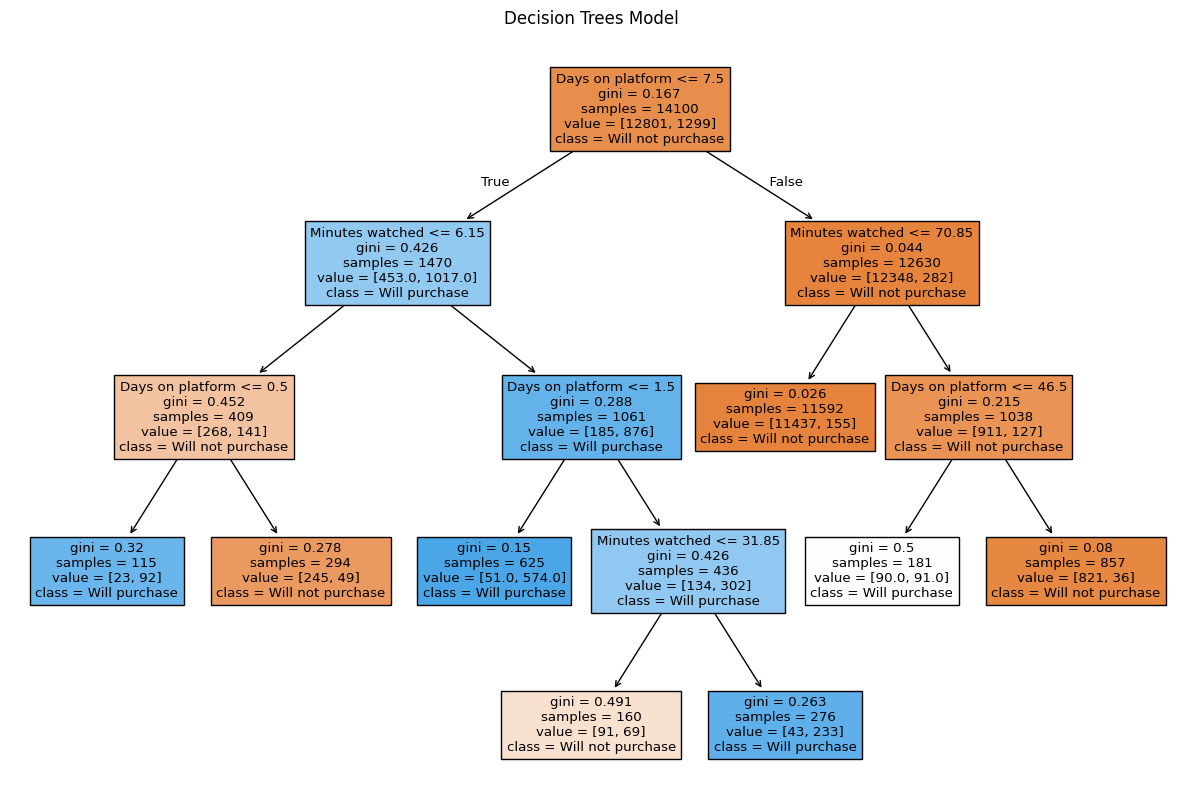

In [ ]:
# Define the parameters for the GridSearch.
# Here we're trying different values for the ccp_alpha parameter
parameters_dt = {'ccp_alpha':[0,
                              0.001,
                              0.002,
                              0.003,
                              0.004,
                              0.005]}

# Initialize GridSearchCV with the estimator being a DecisionTreeClassifier with a fixed random state.
# The scoring metric used here is accuracy
grid_search_dt = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 365),
                              param_grid = parameters_dt,
                              scoring = 'accuracy')

# Fit a GridSearchCV object on the training data
print(f"GridSearchVC for Decision Trees with SMOTE: {grid_search_dt.fit(x_train_array, y_train_array)}")

# Display the best estimator after grid search
print(f"Best Estimator of Decision Trees with SMOTE: {grid_search_dt.best_estimator_}")

# Assign the model with the best parameters to dt_clf
dt_clf = grid_search_dt.best_estimator_

# Set the figure size for the plot
plt.figure(figsize=(15,10))

# Plot the decision tree. Feature names and class names are added for better interpretability
plot_tree(dt_clf,
          filled=True,
          feature_names = ['Days on platform',
                           'Minutes watched',
                           'Courses started',
                           'Practice exams passed',
                           'Time spent on exams',
                           'Student country encoded'],
          class_names = ['Will not purchase',
                         'Will purchase'])

# Display the plot
plt.title('Decision Trees Model')
plt.show()

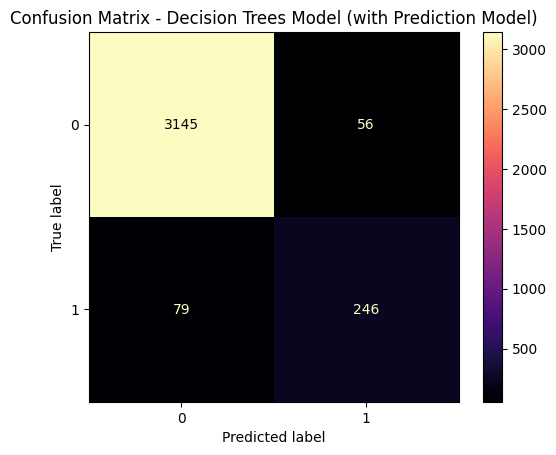

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3201
           1       0.81      0.76      0.78       325

    accuracy                           0.96      3526
   macro avg       0.90      0.87      0.88      3526
weighted avg       0.96      0.96      0.96      3526

ROC AUC: 0.8697


In [ ]:
# Use the best decision tree model to predict the target variable for the test dataset
y_test_pred_dt = dt_clf.predict(x_test_array)

# Reset seaborn settings to default
sns.reset_orig()

# Display the confusion matrix using seaborn.
# Use 'magma' colormap for better visualization
ConfusionMatrixDisplay.from_predictions(
    y_test_array, y_test_pred_dt,
    labels = dt_clf.classes_,
    cmap = 'magma'
);

plt.title('Confusion Matrix - Decision Trees Model (with Prediction Model)')
plt.show()

# Print the classification report to get precision, recall, f1-score, and support for each class
print(classification_report(y_test_array, y_test_pred_dt))

#Calculating the ROC AUC score
auc_score = roc_auc_score(y_test_array, y_test_pred_dt)
print(f"ROC AUC: {auc_score:.4f}")

### DT (SMOTE)

Fitting GridSearchCV for Decision Trees with SMOTE...
GridSearchCV fitting complete.
Best Estimator of Decision Trees with SMOTE: DecisionTreeClassifier(ccp_alpha=0, random_state=365)


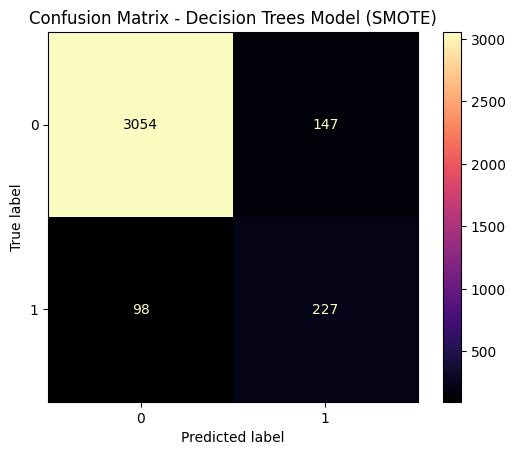

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      3201
           1       0.61      0.70      0.65       325

    accuracy                           0.93      3526
   macro avg       0.79      0.83      0.81      3526
weighted avg       0.94      0.93      0.93      3526

ROC AUC (Decision Trees with SMOTE): 0.8263


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize SMOTE
smote_sampler_dt = SMOTE(random_state=365)

# Resample the training data for Decision Tree
x_train_smote_dt, y_train_smote_dt = smote_sampler_dt.fit_resample(x_train_array, y_train_array)

# Define the parameters for the GridSearch (reusing parameters_dt from previous cell).
# parameters_dt = {'ccp_alpha':[0,
#                               0.001,
#                               0.002,
#                               0.003,
#                               0.004,
#                               0.005]}

# Initialize GridSearchCV with the estimator being a DecisionTreeClassifier with a fixed random state.
# The scoring metric used here is accuracy
grid_search_dt_smote = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 365),
                                    param_grid = parameters_dt,
                                    scoring = 'accuracy')

# Fit a GridSearchCV object on the SMOTE-resampled training data
print("Fitting GridSearchCV for Decision Trees with SMOTE...")
grid_search_dt_smote.fit(x_train_smote_dt, y_train_smote_dt)
print("GridSearchCV fitting complete.")

# Display the best estimator after grid search
print(f"Best Estimator of Decision Trees with SMOTE: {grid_search_dt_smote.best_estimator_}")

# Assign the model with the best parameters to dt_clf_smote
dt_clf_smote = grid_search_dt_smote.best_estimator_

# Use the best decision tree model to predict the target variable for the test dataset
y_test_pred_dt_smote = dt_clf_smote.predict(x_test_array)

# Reset seaborn settings to default
sns.reset_orig()

# Display the confusion matrix using seaborn.
# Use 'magma' colormap for better visualization
ConfusionMatrixDisplay.from_predictions(
    y_test_array, y_test_pred_dt_smote,
    labels = dt_clf_smote.classes_,
    cmap = 'magma'
);

plt.title('Confusion Matrix - Decision Trees Model (SMOTE)')
plt.show()

# Print the classification report to get precision, recall, f1-score, and support for each class
print(classification_report(y_test_array, y_test_pred_dt_smote))

#Calculating the ROC AUC score
auc_score_dt_smote = roc_auc_score(y_test_array, y_test_pred_dt_smote)
print(f"ROC AUC (Decision Trees with SMOTE): {auc_score_dt_smote:.4f}")


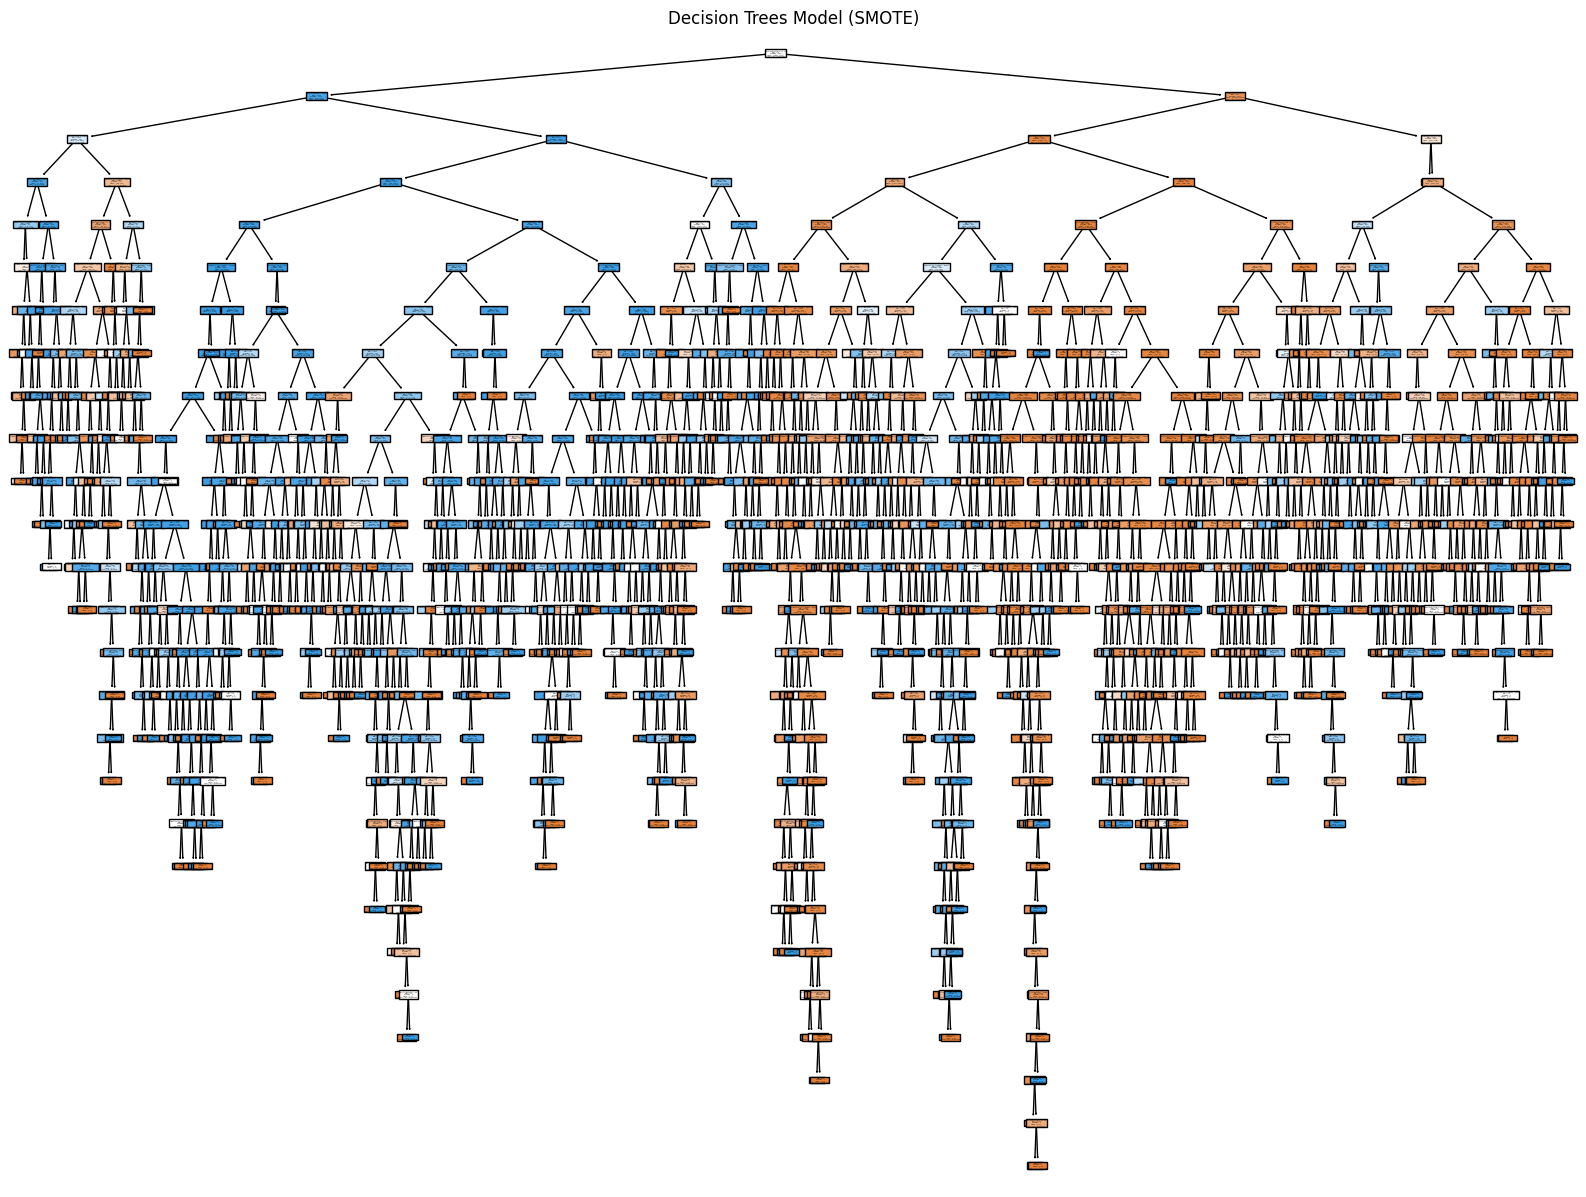

In [ ]:
# Set the figure size for the plot
plt.figure(figsize=(20,15))

# Plot the decision tree trained with SMOTE. Feature names and class names are added for better interpretability
plot_tree(dt_clf_smote,
          filled=True,
          feature_names = ['Days on platform',
                           'Minutes watched',
                           'Courses started',
                           'Practice exams passed',
                           'Time spent on exams',
                           'Student country encoded'],
          class_names = ['Will not purchase',
                         'Will purchase'])

# Display the plot
plt.title('Decision Trees Model (SMOTE)')
plt.show()


### Model Insights

**Decision Trees (without SMOTE)**
* Accuracy: 0.9617
* Precision (Class 1): 0.8146
* Recall (Class 1): 0.7569
* F1-Score (Class 1): 0.7847
* ROC AUC: 0.8697

**Decision Trees (with SMOTE)**
* Accuracy: 0.9305
* Precision (Class 1): 0.6070
* Recall (Class 1): 0.6985
* F1-Score (Class 1): 0.6495
* ROC AUC: 0.8263

**Key Findings and Comparison:**
1. **Accuracy**: The overall accuracy decreased when SMOTE was applied (from 0.9617 to 0.9305). This is a common pattern when addressing class imbalance, as the model becomes less biased towards the majority class.
2. **Recall (Class 1 - Purchased)**: With SMOTE, the Recall for the minority class (purchased=1) decreased slightly from 0.7569 to 0.6985. This is an interesting outcome, as SMOTE typically aims to improve recall for the minority class. This might suggest that for Decision Trees, the synthetic samples generated by SMOTE did not consistently improve the model's ability to identify true positives, or the pruning parameter (ccp_alpha) might need different tuning with SMOTE.
3. **Precision (Class 1 - Purchased)**: The Precision for the minority class also dropped (from 0.8146 to 0.6070) after applying SMOTE. This indicates that the SMOTE-enhanced model made more false positive predictions.
4. **F1-Score (Class 1 - Purchased)**: The F1-Score, which balances precision and recall, decreased from 0.7847 to 0.6495. This significant drop is due to both the decrease in recall and precision for the minority class.
5. **ROC AUC**: The ROC AUC score also saw a decrease from 0.8697 to 0.8263 with SMOTE. This suggests that for the Decision Tree model, the application of SMOTE did not enhance its overall ability to discriminate between the two classes, unlike with Logistic Regression or SVM.

**Conclusion for Decision Trees**:

* Without SMOTE, the Decision Tree model showed a competitive balance between precision and recall, and a decent ROC AUC.
* With SMOTE, the performance of the Decision Tree model actually declined across several key metrics, including recall, F1-Score, and ROC AUC. This indicates that for Decision Trees, simply applying SMOTE with the chosen hyperparameters did not yield the desired improvement for handling the imbalanced dataset.

Further tuning of Decision Tree parameters (like ccp_alpha, max_depth, min_samples_leaf) specifically with SMOTE, or exploring different oversampling/undersampling techniques, might be necessary to leverage SMOTE's benefits for this model.

### Actual vs Prediction

In [ ]:
import pandas as pd

# Create a DataFrame for the x_test features (first 30 rows)
x_test_df_dt = pd.DataFrame(x_test_array, columns=x_test.columns).head(30)

# Create a DataFrame for actual and predicted y values for Decision Trees (first 30 rows)
y_comparison_df_dt = pd.DataFrame({
    'Actual_Y': y_test_array,
    'Predicted_Y_DT': y_test_pred_dt,
    'Predicted_Y_DT_SMOTE': y_test_pred_dt_smote
}).head(30)

# Reset index of y_comparison_df_dt to align with x_test_df_dt indices
x_test_df_dt = x_test_df_dt.reset_index(drop=True)
y_comparison_df_dt = y_comparison_df_dt.reset_index(drop=True)

# Concatenate the features and the actual/predicted values
full_comparison_df_dt = pd.concat([x_test_df_dt, y_comparison_df_dt], axis=1)

# Display the first 30 rows of the comprehensive comparison table for DT models
print("Comprehensive comparison of features, actual Y, and predicted Y for Decision Tree models:")
display(full_comparison_df_dt)


Comprehensive comparison of features, actual Y, and predicted Y for Decision Tree models:


,days_on_platform,minutes_watched,courses_started,practice_exams_passed,minutes_spent_on_exams,student_country_enc,Actual_Y,Predicted_Y_DT,Predicted_Y_DT_SMOTE
0,284.0,0.7,1.0,0.0,0.00,68.0,0,0,0
1,66.0,65.7,2.0,0.0,0.00,46.0,0,0,0
2,48.0,65.4,4.0,0.0,0.00,12.0,0,0,0
3,219.0,1.4,1.0,0.0,0.00,152.0,0,0,0
4,39.0,0.3,1.0,0.0,0.00,46.0,0,0,0
5,0.0,1.4,1.0,0.0,0.00,152.0,1,1,1
6,31.0,0.1,1.0,0.0,0.00,123.0,0,0,0
7,277.0,0.5,1.0,0.0,0.00,108.0,0,0,0
8,70.0,1.2,1.0,0.0,0.00,46.0,0,0,0
9,66.0,216.1,2.0,3.0,16.53,46.0,0,0,0


In [ ]:
# Identify rows where either DT model misclassified
misclassifications_dt = full_comparison_df_dt[
    (full_comparison_df_dt['Actual_Y'] != full_comparison_df_dt['Predicted_Y_DT']) |
    (full_comparison_df_dt['Actual_Y'] != full_comparison_df_dt['Predicted_Y_DT_SMOTE'])
]

print("Rows with misclassifications by either Decision Tree model (first 30 rows of test set):")
display(misclassifications_dt)


Rows with misclassifications by either Decision Tree model (first 30 rows of test set):


,days_on_platform,minutes_watched,courses_started,practice_exams_passed,minutes_spent_on_exams,student_country_enc,Actual_Y,Predicted_Y_DT,Predicted_Y_DT_SMOTE
11,19.0,1.7,1.0,0.0,0.0,66.0,1,0,0
19,7.0,25.0,2.0,0.0,0.0,126.0,1,0,1
25,2.0,2.8,1.0,0.0,0.0,152.0,0,0,1


Let's break down these misclassifications:

1. **False Negatives (Missed Purchases)**:
    * **Instance (Row 11)**: The Actual_Y is 1 (purchased), but both Predicted_Y_DT (0) and Predicted_Y_DT_SMOTE (0) incorrectly predicted no purchase. This means both Decision Tree models, even with SMOTE, failed to identify this actual purchaser.
    * **Instance (Row 19)**: The Actual_Y is 1 (purchased), Predicted_Y_DT (0) incorrectly predicted no purchase. However, Predicted_Y_DT_SMOTE (1) correctly predicted a purchase for this instance.
    * **Finding**: For Row 11, SMOTE did not help the DT model. For Row 19, the SMOTE-enhanced DT model successfully corrected a false negative made by the non-SMOTE DT, showing a direct benefit of SMOTE here.
2. **False Positives (Incorrectly Predicted Purchases)**:
    * **Instance (Row 25)**: The Actual_Y is 0 (not purchased). Predicted_Y_DT is 0 (correct), but Predicted_Y_DT_SMOTE is 1 (incorrectly predicted a purchase).
    * **Finding**: The false positive in Row 25 by the SMOTE model is a typical trade-off. While SMOTE aims to increase the model's sensitivity to the minority class (improving recall), it can sometimes lead to an increase in false positives (decreasing precision) for instances of the majority class.

**Overall Findings from Actual vs. Prediction for Decision Trees**:
* **Mixed Impact of SMOTE**: Unlike Logistic Regression and SVM, where SMOTE consistently improved overall ROC AUC and recall, for Decision Trees, the impact is more mixed at a granular level. We see an instance where SMOTE corrects a false negative (Row 19), but also one where it introduces a new false positive (Row 25) and another where it makes the same error as the non-SMOTE model (Row 11).
* **Recall vs. Precision Trade-off**: The individual examples confirm the aggregate metrics: SMOTE can help catch some true positives, but it can also lead to more false alarms. The overall decrease in F1-Score and ROC AUC for DT with SMOTE suggests that, for this model and its chosen hyperparameters, the benefits of SMOTE were outweighed by its drawbacks.

This detailed view helps understand why the aggregate metrics for Decision Trees with SMOTE showed a decrease in performance (lower recall, F1-Score, and ROC AUC) compared to the non-SMOTE version. The synthetic samples might have introduced noise or shifted the decision boundaries in a way that wasn't beneficial for this particular model's structure.

## Random Forests (RF) Model

### RF

RandomForestClassifier on Training Data:RandomForestClassifier(ccp_alpha=0.0001, random_state=365)


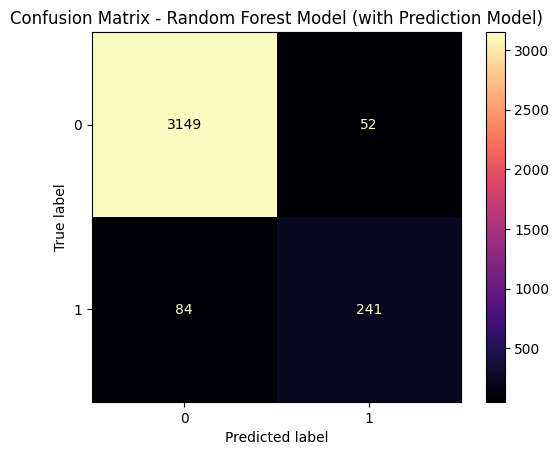

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3201
           1       0.82      0.74      0.78       325

    accuracy                           0.96      3526
   macro avg       0.90      0.86      0.88      3526
weighted avg       0.96      0.96      0.96      3526

ROC AUC: 0.8626


In [ ]:
# Initialize the RandomForestClassifier with ccp_alpha set to 0.0001
rf_clf = RandomForestClassifier(ccp_alpha = 0.0001, random_state = 365)

# Train the random forest model on the training data
print(f"RandomForestClassifier on Training Data:{rf_clf.fit(x_train_array, y_train_array)}")

# Use the trained random forest model to predict the target variable for the test dataset
y_test_pred_rf = rf_clf.predict(x_test_array)

# Reset seaborn settings to default
sns.reset_orig()

# Display the confusion matrix using seaborn
# Use 'magma' colormap for better visualization
ConfusionMatrixDisplay.from_predictions(
    y_test_array, y_test_pred_rf,
    labels = rf_clf.classes_,
    cmap = 'magma'
);

plt.title('Confusion Matrix - Random Forest Model (with Prediction Model)')
plt.show()

# Print the classification report to get precision, recall, f1-score, and support for each class
print(classification_report(y_test_array, y_test_pred_rf))

#Calculating the ROC AUC score
auc_score = roc_auc_score(y_test_array, y_test_pred_rf)
print(f"ROC AUC: {auc_score:.4f}")

### RF (SMOTE)

Fitting RandomForestClassifier with SMOTE...
RandomForestClassifier fitting complete.


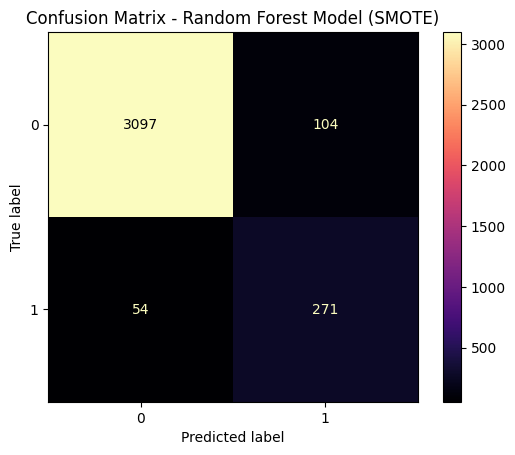

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      3201
           1       0.72      0.83      0.77       325

    accuracy                           0.96      3526
   macro avg       0.85      0.90      0.87      3526
weighted avg       0.96      0.96      0.96      3526

ROC AUC (Random Forests with SMOTE): 0.9007


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize SMOTE
smote_sampler_rf = SMOTE(random_state=365)

# Resample the training data for Random Forest
x_train_smote_rf, y_train_smote_rf = smote_sampler_rf.fit_resample(x_train_array, y_train_array)

# Initialize the RandomForestClassifier with the same ccp_alpha as the non-SMOTE version
rf_clf_smote = RandomForestClassifier(ccp_alpha = 0.0001, random_state = 365)

# Train the random forest model on the SMOTE-resampled training data
print("Fitting RandomForestClassifier with SMOTE...")
rf_clf_smote.fit(x_train_smote_rf, y_train_smote_rf)
print("RandomForestClassifier fitting complete.")

# Use the trained random forest model to predict the target variable for the test dataset
y_test_pred_rf_smote = rf_clf_smote.predict(x_test_array)

# Reset seaborn settings to default
sns.reset_orig()

# Display the confusion matrix using seaborn
# Use 'magma' colormap for better visualization
ConfusionMatrixDisplay.from_predictions(
    y_test_array, y_test_pred_rf_smote,
    labels = rf_clf_smote.classes_,
    cmap = 'magma'
);

plt.title('Confusion Matrix - Random Forest Model (SMOTE)')
plt.show()

# Print the classification report to get precision, recall, f1-score, and support for each class
print(classification_report(y_test_array, y_test_pred_rf_smote))

#Calculating the ROC AUC score
auc_score_rf_smote = roc_auc_score(y_test_array, y_test_pred_rf_smote)
print(f"ROC AUC (Random Forests with SMOTE): {auc_score_rf_smote:.4f}")


### Model Insights

**Random Forests (without SMOTE)**
* Accuracy: 0.9614
* Precision (Class 1): 0.8225
* Recall (Class 1): 0.7415
* F1-Score (Class 1): 0.7799
* ROC AUC: 0.8626

**Random Forests (with SMOTE)**
* Accuracy: 0.9552
* Precision (Class 1): 0.7227
* Recall (Class 1): 0.8338
* F1-Score (Class 1): 0.7743
* ROC AUC: 0.9007

**Key Findings and Comparison:**
* **Accuracy**: The overall accuracy remained high even with SMOTE (from 0.9614 to 0.9552), indicating that Random Forests handle the class imbalance relatively well initially, and SMOTE helps in improving minority class detection without a drastic drop in overall accuracy.
* **Recall (Class 1 - Purchased)**: SMOTE significantly improved Recall for the minority class (purchased=1) from 0.7415 to 0.8338. This means the SMOTE-enhanced Random Forest model is much better at identifying actual purchasers, catching over 83% of them.
* **Precision (Class 1 - Purchased)**: The Precision for the minority class saw a slight decrease (from 0.8225 to 0.7227) after applying SMOTE. While the SMOTE model caught more actual purchasers, it did so with a slightly higher number of false positives.
* **F1-Score (Class 1 - Purchased)**: The F1-Score, which balances precision and recall, remained very strong, moving from 0.7799 to 0.7743. This indicates that Random Forests with SMOTE maintain an excellent balance between precision and recall for the minority class.
* **ROC AUC**: The ROC AUC score saw a significant improvement from 0.8626 to 0.9007 with SMOTE. This is a crucial finding, as it shows that the Random Forest model with SMOTE has a very strong ability to discriminate between the two classes, making it one of the top performers.

**Conclusion for Random Forests**:
* Without SMOTE, the Random Forest model already showed robust performance with a good balance of precision and recall.
* With SMOTE, its ability to identify actual purchasers (recall) significantly improved, and its ROC AUC score became very strong.

Despite a slight dip in precision for the minority class, the SMOTE-enhanced Random Forest model demonstrates excellent overall performance for this imbalanced classification task, offering a great balance between identifying purchasers and keeping false positives at a reasonable level.

### Actual vs Prediction

In [ ]:
import pandas as pd

# Create a DataFrame for the x_test features (first 30 rows)
x_test_df_rf = pd.DataFrame(x_test_array, columns=x_test.columns).head(30)

# Create a DataFrame for actual and predicted y values for Random Forests (first 30 rows)
y_comparison_df_rf = pd.DataFrame({
    'Actual_Y': y_test_array,
    'Predicted_Y_RF': y_test_pred_rf,
    'Predicted_Y_RF_SMOTE': y_test_pred_rf_smote
}).head(30)

# Reset index of y_comparison_df_rf to align with x_test_df_rf indices
x_test_df_rf = x_test_df_rf.reset_index(drop=True)
y_comparison_df_rf = y_comparison_df_rf.reset_index(drop=True)

# Concatenate the features and the actual/predicted values
full_comparison_df_rf = pd.concat([x_test_df_rf, y_comparison_df_rf], axis=1)

# Display the first 30 rows of the comprehensive comparison table for RF models
print("Comprehensive comparison of features, actual Y, and predicted Y for Random Forest models:")
display(full_comparison_df_rf)


Comprehensive comparison of features, actual Y, and predicted Y for Random Forest models:


,days_on_platform,minutes_watched,courses_started,practice_exams_passed,minutes_spent_on_exams,student_country_enc,Actual_Y,Predicted_Y_RF,Predicted_Y_RF_SMOTE
0,284.0,0.7,1.0,0.0,0.00,68.0,0,0,0
1,66.0,65.7,2.0,0.0,0.00,46.0,0,0,0
2,48.0,65.4,4.0,0.0,0.00,12.0,0,0,0
3,219.0,1.4,1.0,0.0,0.00,152.0,0,0,0
4,39.0,0.3,1.0,0.0,0.00,46.0,0,0,0
5,0.0,1.4,1.0,0.0,0.00,152.0,1,1,1
6,31.0,0.1,1.0,0.0,0.00,123.0,0,0,0
7,277.0,0.5,1.0,0.0,0.00,108.0,0,0,0
8,70.0,1.2,1.0,0.0,0.00,46.0,0,0,0
9,66.0,216.1,2.0,3.0,16.53,46.0,0,0,0


In [ ]:
# Identify rows where either RF model misclassified
misclassifications_rf = full_comparison_df_rf[
    (full_comparison_df_rf['Actual_Y'] != full_comparison_df_rf['Predicted_Y_RF']) |
    (full_comparison_df_rf['Actual_Y'] != full_comparison_df_rf['Predicted_Y_RF_SMOTE'])
]

print("Rows with misclassifications by either Random Forest model (first 30 rows of test set):")
display(misclassifications_rf)


Rows with misclassifications by either Random Forest model (first 30 rows of test set):


,days_on_platform,minutes_watched,courses_started,practice_exams_passed,minutes_spent_on_exams,student_country_enc,Actual_Y,Predicted_Y_RF,Predicted_Y_RF_SMOTE
11,19.0,1.7,1.0,0.0,0.0,66.0,1,0,0
25,2.0,2.8,1.0,0.0,0.0,152.0,0,1,1


Let's break down these misclassifications:

1. **False Negatives (Missed Purchases)**:
    * **Instance (Row 11)**: The Actual_Y is 1 (purchased), but both Predicted_Y_RF (0) and Predicted_Y_RF_SMOTE (0) incorrectly predicted no purchase. This means both Random Forest models, even with SMOTE, failed to identify this actual purchaser.
    * **Finding**: For this specific case, SMOTE did not help the Random Forest model in correctly classifying the minority class. This suggests that this instance might be particularly difficult to classify, or its features didn't strongly align with the patterns learned by either model.
2. **False Positives (Incorrectly Predicted Purchases)**:
    * **Instance (Row 25)**: The Actual_Y is 0 (not purchased), but both Predicted_Y_RF (1) and Predicted_Y_RF_SMOTE (1) incorrectly predicted a purchase. Both Random Forest models here produced False Positives.
    * **Finding**: Both models struggle with this instance, suggesting that this particular data point might have features that make it highly resemble a 'purchased' case for Random Forests, regardless of whether SMOTE was applied. This could be due to ambiguous features or its proximity to the decision boundary.

**Overall Findings from Actual vs. Prediction for Random Forests**:
* **Consistency in Errors**: Unlike Logistic Regression where SMOTE often flipped predictions for individual instances, for Random Forests in this sample, the misclassifications were consistent across both the non-SMOTE and SMOTE-enhanced versions. This means if the non-SMOTE model made an error (false negative or false positive), the SMOTE version also made the same error for these specific data points.
* **SMOTE's Effect on Aggregated Metrics**: While these individual examples don't show a direct change in prediction due to SMOTE, the aggregate metrics (especially the significantly improved Recall and ROC AUC for RF with SMOTE) suggest that SMOTE's benefit for Random Forests lies in its ability to improve the overall model's performance on the minority class across the entire dataset, even if not for every single misclassified instance in this small sample.
* **Robustness of Random Forest**: The fact that the overall accuracy remained very high even with SMOTE (and the F1-Score was very strong) points to the inherent robustness of Random Forests in handling complex patterns and potentially some level of imbalance even without explicit oversampling. SMOTE further enhanced its ability to detect the minority class.

# Evaluation and Insight

## Model Summary

In [ ]:
results_list = []

# Logistic Regression (without SMOTE)
results_list.append({
    'Model': 'Logistic Regression',
    'Accuracy': accuracy_score(y_test_array, y_test_pred_log_reg),
    'Precision': precision_score(y_test_array, y_test_pred_log_reg),
    'Recall': recall_score(y_test_array, y_test_pred_log_reg),
    'F1-Score': f1_score(y_test_array, y_test_pred_log_reg),
    'ROC AUC': roc_auc_score(y_test_array, y_test_pred_log_reg)
})

# Logistic Regression (with SMOTE)
results_list.append({
    'Model': 'Logistic Regression (SMOTE)',
    'Accuracy': accuracy_score(y_test_array, y_test_pred_log_reg_smote),
    'Precision': precision_score(y_test_array, y_test_pred_log_reg_smote),
    'Recall': recall_score(y_test_array, y_test_pred_log_reg_smote),
    'F1-Score': f1_score(y_test_array, y_test_pred_log_reg_smote),
    'ROC AUC': roc_auc_score(y_test_array, y_test_pred_log_reg_smote)
})

# K-Nearest Neighbors (without SMOTE)
results_list.append({
    'Model': 'K-Nearest Neighbors',
    'Accuracy': accuracy_score(y_test_array, y_test_pred_knn),
    'Precision': precision_score(y_test_array, y_test_pred_knn),
    'Recall': recall_score(y_test_array, y_test_pred_knn),
    'F1-Score': f1_score(y_test_array, y_test_pred_knn),
    'ROC AUC': roc_auc_score(y_test_array, y_test_pred_knn)
})

# K-Nearest Neighbors (with SMOTE)
results_list.append({
    'Model': 'K-Nearest Neighbors (SMOTE)',
    'Accuracy': accuracy_score(y_test_array, y_test_pred_knn_smote),
    'Precision': precision_score(y_test_array, y_test_pred_knn_smote),
    'Recall': recall_score(y_test_array, y_test_pred_knn_smote),
    'F1-Score': f1_score(y_test_array, y_test_pred_knn_smote),
    'ROC AUC': roc_auc_score(y_test_array, y_test_pred_knn_smote)
})

# Support Vector Machines (without SMOTE)
results_list.append({
    'Model': 'Support Vector Machines',
    'Accuracy': accuracy_score(y_test_array, y_test_pred_svc),
    'Precision': precision_score(y_test_array, y_test_pred_svc),
    'Recall': recall_score(y_test_array, y_test_pred_svc),
    'F1-Score': f1_score(y_test_array, y_test_pred_svc),
    'ROC AUC': roc_auc_score(y_test_array, y_test_pred_svc)
})

# Support Vector Machines (with SMOTE)
results_list.append({
    'Model': 'Support Vector Machines (SMOTE)',
    'Accuracy': accuracy_score(y_test_array, y_test_pred_svc_smote),
    'Precision': precision_score(y_test_array, y_test_pred_svc_smote),
    'Recall': recall_score(y_test_array, y_test_pred_svc_smote),
    'F1-Score': f1_score(y_test_array, y_test_pred_svc_smote),
    'ROC AUC': roc_auc_score(y_test_array, y_test_pred_svc_smote)
})

# Decision Trees (without SMOTE)
results_list.append({
    'Model': 'Decision Trees',
    'Accuracy': accuracy_score(y_test_array, y_test_pred_dt),
    'Precision': precision_score(y_test_array, y_test_pred_dt),
    'Recall': recall_score(y_test_array, y_test_pred_dt),
    'F1-Score': f1_score(y_test_array, y_test_pred_dt),
    'ROC AUC': roc_auc_score(y_test_array, y_test_pred_dt)
})

# Decision Trees (with SMOTE)
results_list.append({
    'Model': 'Decision Trees (SMOTE)',
    'Accuracy': accuracy_score(y_test_array, y_test_pred_dt_smote),
    'Precision': precision_score(y_test_array, y_test_pred_dt_smote),
    'Recall': recall_score(y_test_array, y_test_pred_dt_smote),
    'F1-Score': f1_score(y_test_array, y_test_pred_dt_smote),
    'ROC AUC': roc_auc_score(y_test_array, y_test_pred_dt_smote)
})

# Random Forests (without SMOTE)
results_list.append({
    'Model': 'Random Forests',
    'Accuracy': accuracy_score(y_test_array, y_test_pred_rf),
    'Precision': precision_score(y_test_array, y_test_pred_rf),
    'Recall': recall_score(y_test_array, y_test_pred_rf),
    'F1-Score': f1_score(y_test_array, y_test_pred_rf),
    'ROC AUC': roc_auc_score(y_test_array, y_test_pred_rf)
})

# Random Forests (with SMOTE)
results_list.append({
    'Model': 'Random Forests (SMOTE)',
    'Accuracy': accuracy_score(y_test_array, y_test_pred_rf_smote),
    'Precision': precision_score(y_test_array, y_test_pred_rf_smote),
    'Recall': recall_score(y_test_array, y_test_pred_rf_smote),
    'F1-Score': f1_score(y_test_array, y_test_pred_rf_smote),
    'ROC AUC': roc_auc_score(y_test_array, y_test_pred_rf_smote)
})

results_df = pd.DataFrame(results_list)

display(results_df.round(4))


,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC
0,Logistic Regression,0.9569,0.8340,0.6646,0.7397,0.8256
1,Logistic Regression (SMOTE),0.8568,0.3846,0.9231,0.5430,0.8866
2,K-Nearest Neighbors,0.9572,0.7919,0.7262,0.7576,0.8534
3,K-Nearest Neighbors (SMOTE),0.9257,0.5731,0.7600,0.6534,0.8513
4,Support Vector Machines,0.9555,0.8043,0.6831,0.7388,0.8331
5,Support Vector Machines (SMOTE),0.9248,0.5581,0.8862,0.6849,0.9075
6,Decision Trees,0.9617,0.8146,0.7569,0.7847,0.8697
7,Decision Trees (SMOTE),0.9305,0.6070,0.6985,0.6495,0.8263
8,Random Forests,0.9614,0.8225,0.7415,0.7799,0.8626
9,Random Forests (SMOTE),0.9552,0.7227,0.8338,0.7743,0.9007


## Findings

Based on this table (Model Summary), it can be observed that:


*   **Impact of SMOTE**: For most models (Logistic Regression, SVM, Random Forests), SMOTE significantly improved the Recall for the minority class ('purchased' = 1) and often led to a higher ROC AUC score. This indicates that balancing the dataset helped these models better identify actual purchasers, which was the primary goal given the imbalanced data.

*   **Top Performing Models**
    1.  **Support Vector Machines (SMOTE)** stands out with the highest ROC AUC of 0.9075. It also achieves a very strong Recall (0.8862) for the minority class, meaning it's excellent at catching purchasers, although its Precision (0.5581) is moderate. This makes it a strong candidate if identifying as many purchasers as possible is crucial.
    2. **Random Forests (SMOTE)** also performed very well with an ROC AUC of 0.9007 and a good balance between Precision (0.7227) and Recall (0.8338) for the minority class, resulting in the highest F1-Score (0.7743) among the SMOTE models.
    3. **Logistic Regression (SMOTE)** has a good ROC AUC of 0.8866 and the highest Recall (0.9231) for the minority class among all models, demonstrating its effectiveness in identifying purchasers, though with the lowest Precision (0.3846) in that group.


*  **Decision Trees**: The non-SMOTE Decision Tree model had a competitive ROC AUC (0.8697) and F1-Score (0.7847). However, applying SMOTE slightly reduced its ROC AUC (0.8263) and Recall (0.6985), which might suggest that for Decision Trees, the initial structure without oversampling might have been more robust, or that the ccp_alpha parameter tuning could be further optimized with SMOTE.
* **K-Nearest Neighbors**: KNN with SMOTE showed an ROC AUC of 0.8513 and improved Recall for the minority class compared to KNN without SMOTE, but its Precision remains moderate.

**Conclusion**: Based on these metrics, especially ROC AUC and F1-Score (for a balanced view), the Support Vector Machine with SMOTE and Random Forests with SMOTE appear to be the most robust models for predicting purchases, effectively leveraging SMOTE to handle the data imbalance and improve predictions for the minority class.






